In [25]:
"""
This code merges the scores and vote data from show_scores.csv into netflix_title.csv. The process is divided into two steps:

1) First, it compares whether the titles in the two datasets match. If they do, it cleans the stars data from show_scores.csv and 
saves it as a new column called castname. Then, it checks if at least two names are the same between the castname and cast columns. 
If both conditions are met, the two entries are considered to represent the same show.

2) The scores and vote data of the same show are appended to the original dataset to create a complete dataset with scores, 
which will be used for further cleaning and analysis.
"""

import pandas as pd

# Load the two CSV files
netflix_df = pd.read_csv('netflix_titles.csv')
scores_df = pd.read_csv('show_scores.csv')

# Normalize titles and names for consistent comparison
netflix_df['title'] = netflix_df['title'].str.strip().str.lower()
netflix_df['cast'] = netflix_df['cast'].fillna('').str.strip().str.lower()
scores_df['title'] = scores_df['title'].str.strip().str.lower()
scores_df['stars'] = scores_df['stars'].fillna('').astype(str)

# Clean and normalize the 'stars' column to create 'castname'
def clean_stars(stars):
    # Remove brackets [ ], "stars:" prefix, single quotes, and split into names
    cleaned_names = stars.replace('[', '').replace(']', '').replace('stars:', '').replace('|', '').strip()
    # Remove single quotes and commas, then convert names to lowercase
    cleaned_names = [name.replace("'", "").replace(",", "").strip().lower() for name in cleaned_names.split(',') if name.strip()]
    return cleaned_names

# Apply the cleaning function to the 'stars' column
scores_df['castname'] = scores_df['stars'].apply(clean_stars)

# Function to check if two shows match based on title and castname/cast
def check_match(row, netflix_data):
    # Filter Netflix rows where the title matches
    matching_titles = netflix_data[netflix_data['title'] == row['title']]
    
    if not matching_titles.empty:
        for _, netflix_row in matching_titles.iterrows():
            # Extract and compare cast and castname
            cast = set(str(netflix_row['cast']).split(', '))
            castname = set(row['castname'])  # Already cleaned as a list
            
            # Check if there are at least 2 common names
            if len(cast.intersection(castname)) >= 2:
                return True
    return False

# Create a list to store results
results = []

# Iterate through rows in show_scores.csv
for _, row in scores_df.iterrows():
    if check_match(row, netflix_df):
        results.append({
            'title2': row['title'],
            'castname': row['castname'],  # Store the cleaned castname instead of stars
            'scores': row['rating'],  # Rename 'rating' to 'scores'
            'votes': row['votes']
        })

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Merge the results back into the Netflix DataFrame
# Align titles by merging the additional columns
final_df = pd.merge(netflix_df, results_df, left_on='title', right_on='title2', how='left')

# Drop the duplicate title column ('title2')
final_df = final_df.drop(columns=['title2'])
final_df = final_df.drop(columns=['castname'])

# Save the final DataFrame to a new CSV file
final_df.to_csv('netflix_show_with_scores.csv', index=False)

# Print the top rows of the final merged DataFrame
print("\nFinal Merged DataFrame (Top Rows):")
final_df.head()


Final Merged DataFrame (Top Rows):


show_id     type                  title         director  \
0      s1    Movie   dick johnson is dead  Kirsten Johnson   
1      s2  TV Show          blood & water              NaN   
2      s2  TV Show          blood & water              NaN   
3      s3  TV Show              ganglands  Julien Leclercq   
4      s4  TV Show  jailbirds new orleans              NaN   

                                                cast        country  \
0                                                     United States   
1  ama qamata, khosi ngema, gail mabalane, thaban...   South Africa   
2  ama qamata, khosi ngema, gail mabalane, thaban...   South Africa   
3  sami bouajila, tracy gotoas, samuel jouy, nabi...            NaN   
4                                                               NaN   

           date_added  release_year rating   duration  \
0  September 25, 2021          2020  PG-13     90 min   
1  September 24, 2021          2021  TV-MA  2 Seasons   
2  September 24, 2021          2021  TV-MA  2 Seasons   
3  September 24, 2021          2021  TV-MA   1 Season   
4  September 24, 2021          2021  TV-MA   1 Season   

                                           listed_in  \
0                                      Documentaries   
1    International TV Shows, TV Dramas, TV Mysteries   
2    International TV Shows, TV Dramas, TV Mysteries   
3  Crime TV Shows, International TV Shows, TV Act...   
4                             Docuseries, Reality TV   

                                         description  scores  votes  
0  As her father nears the end of his life, filmm...     NaN    NaN  
1  After crossing paths at a party, a Cape Town t...     6.6  3,180  
2  After crossing paths at a party, a Cape Town t...     7.0    120  
3  To protect his family from a powerful drug lor...     7.0  2,640  
4  Feuds, flirtations and toilet talk go down amo...     NaN    NaN

In [26]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Load the dataset
df = pd.read_csv('netflix_show_with_scores.csv')

# Fill missing values selectively
text_cols = ['type', 'title', 'director', 'cast', 'country', 'rating', 'listed_in', 'scores', 'votes']
df[text_cols] = df[text_cols].fillna("Unknown")
df[text_cols] = df[text_cols].apply(lambda x: x.str.strip().str.lower())
df[text_cols] = df[text_cols].apply(lambda x: x.fillna('Unknown').str.strip().str.lower())
df['scores'] = df['scores'].fillna(0)  # Replace NaN with 0 for numeric columns
df['votes'] = df['votes'].fillna(0)

# Normalize and process other columns
df.columns = df.columns.str.lower().str.replace(' ', '_')
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')

# Extract duration data
df['duration_minutes'] = df['duration'].str.extract(r'(\d+)\s*min', expand=False).astype('float')
df['duration_seasons'] = df['duration'].str.extract(r'(\d+)\s*season', expand=False).astype('float')
df['duration_minutes'] = df['duration_minutes'].fillna(0)
df['duration_seasons'] = df['duration_seasons'].fillna(0)

# Drop the original 'duration' column
df.drop(columns=['duration'], inplace=True)

# Remove duplicate rows
df.drop_duplicates(inplace=True)

# Display the cleaned DataFrame
df.head()

show_id     type                  title         director  \
0      s1    movie   dick johnson is dead  kirsten johnson   
1      s2  tv show          blood & water          unknown   
2      s2  tv show          blood & water          unknown   
3      s3  tv show              ganglands  julien leclercq   
4      s4  tv show  jailbirds new orleans          unknown   

                                                cast        country  \
0                                            unknown  united states   
1  ama qamata, khosi ngema, gail mabalane, thaban...   south africa   
2  ama qamata, khosi ngema, gail mabalane, thaban...   south africa   
3  sami bouajila, tracy gotoas, samuel jouy, nabi...        unknown   
4                                            unknown        unknown   

  date_added  release_year rating  \
0 2021-09-25          2020  pg-13   
1 2021-09-24          2021  tv-ma   
2 2021-09-24          2021  tv-ma   
3 2021-09-24          2021  tv-ma   
4 2021-09-24          2021  tv-ma   

                                           listed_in  \
0                                      documentaries   
1    international tv shows, tv dramas, tv mysteries   
2    international tv shows, tv dramas, tv mysteries   
3  crime tv shows, international tv shows, tv act...   
4                             docuseries, reality tv   

                                         description   scores    votes  \
0  As her father nears the end of his life, filmm...  unknown  unknown   
1  After crossing paths at a party, a Cape Town t...  unknown    3,180   
2  After crossing paths at a party, a Cape Town t...  unknown      120   
3  To protect his family from a powerful drug lor...  unknown    2,640   
4  Feuds, flirtations and toilet talk go down amo...  unknown  unknown   

   duration_minutes  duration_seasons  
0              90.0               0.0  
1               0.0               0.0  
2               0.0               0.0  
3               0.0               0.0  
4               0.0               0.0

In [27]:
"""
Count the character number of the title
"""
df['title_length'] = df['title'].apply(len)  
df['word_count'] = df['title'].apply(lambda x: len(x.split()))
df.head()

show_id     type                  title         director  \
0      s1    movie   dick johnson is dead  kirsten johnson   
1      s2  tv show          blood & water          unknown   
2      s2  tv show          blood & water          unknown   
3      s3  tv show              ganglands  julien leclercq   
4      s4  tv show  jailbirds new orleans          unknown   

                                                cast        country  \
0                                            unknown  united states   
1  ama qamata, khosi ngema, gail mabalane, thaban...   south africa   
2  ama qamata, khosi ngema, gail mabalane, thaban...   south africa   
3  sami bouajila, tracy gotoas, samuel jouy, nabi...        unknown   
4                                            unknown        unknown   

  date_added  release_year rating  \
0 2021-09-25          2020  pg-13   
1 2021-09-24          2021  tv-ma   
2 2021-09-24          2021  tv-ma   
3 2021-09-24          2021  tv-ma   
4 2021-09-24          2021  tv-ma   

                                           listed_in  \
0                                      documentaries   
1    international tv shows, tv dramas, tv mysteries   
2    international tv shows, tv dramas, tv mysteries   
3  crime tv shows, international tv shows, tv act...   
4                             docuseries, reality tv   

                                         description   scores    votes  \
0  As her father nears the end of his life, filmm...  unknown  unknown   
1  After crossing paths at a party, a Cape Town t...  unknown    3,180   
2  After crossing paths at a party, a Cape Town t...  unknown      120   
3  To protect his family from a powerful drug lor...  unknown    2,640   
4  Feuds, flirtations and toilet talk go down amo...  unknown  unknown   

   duration_minutes  duration_seasons  title_length  word_count  
0              90.0               0.0            20           4  
1               0.0               0.0            13           3  
2               0.0               0.0            13           3  
3               0.0               0.0             9           1  
4               0.0               0.0            21           3

In [28]:
"""
This code processes the 'rating' column to categorize shows into age-based groups for better audience analysis.
Here’s what it does and why:

1. **Define a Mapping for Ratings**:
   - Create a dictionary to map rating values (e.g., 'G', 'PG-13') to corresponding age groups (e.g., 'all ages', 'teen and above').
   - This helps standardize and group diverse rating formats into meaningful categories.

2. **Map Ratings to Age Groups**:
   - Apply the mapping to the 'rating' column, creating a new column, 'age_group', with the respective age group for each show.
   - This makes it easier to analyze shows by their intended audience demographic.

3. **Verify Results**:
   - Display the first few rows of the dataset to confirm the 'age_group' column has been added and correctly mapped.
"""

# Define a mapping of rating values to age groups
rating_age_mapping = {
    'g': 'all ages',
    'tv-y': 'all ages',
    'tv-g': 'all ages',
    'pg': 'teen and above',
    'pg-13': 'teen and above',
    'tv-y7': 'teen and above',
    'tv-pg': 'teen and above',
    'r': 'adult',
    'tv-14': 'adult',
    'tv-ma': 'adult',
    'nc-17': 'restricted',
    'unknown': 'uncategorized',  # For unknown or missing ratings
    'nr': 'uncategorized'       # "NR" means Not Rated
}

# Map the rating column to the corresponding age group using the defined mapping
df['age_group'] = df['rating'].map(rating_age_mapping)

# Display the results to verify the new age_group column
df.head()

show_id     type                  title         director  \
0      s1    movie   dick johnson is dead  kirsten johnson   
1      s2  tv show          blood & water          unknown   
2      s2  tv show          blood & water          unknown   
3      s3  tv show              ganglands  julien leclercq   
4      s4  tv show  jailbirds new orleans          unknown   

                                                cast        country  \
0                                            unknown  united states   
1  ama qamata, khosi ngema, gail mabalane, thaban...   south africa   
2  ama qamata, khosi ngema, gail mabalane, thaban...   south africa   
3  sami bouajila, tracy gotoas, samuel jouy, nabi...        unknown   
4                                            unknown        unknown   

  date_added  release_year rating  \
0 2021-09-25          2020  pg-13   
1 2021-09-24          2021  tv-ma   
2 2021-09-24          2021  tv-ma   
3 2021-09-24          2021  tv-ma   
4 2021-09-24          2021  tv-ma   

                                           listed_in  \
0                                      documentaries   
1    international tv shows, tv dramas, tv mysteries   
2    international tv shows, tv dramas, tv mysteries   
3  crime tv shows, international tv shows, tv act...   
4                             docuseries, reality tv   

                                         description   scores    votes  \
0  As her father nears the end of his life, filmm...  unknown  unknown   
1  After crossing paths at a party, a Cape Town t...  unknown    3,180   
2  After crossing paths at a party, a Cape Town t...  unknown      120   
3  To protect his family from a powerful drug lor...  unknown    2,640   
4  Feuds, flirtations and toilet talk go down amo...  unknown  unknown   

   duration_minutes  duration_seasons  title_length  word_count  \
0              90.0               0.0            20           4   
1               0.0               0.0            13           3   
2               0.0               0.0            13           3   
3               0.0               0.0             9           1   
4               0.0               0.0            21           3   

        age_group  
0  teen and above  
1           adult  
2           adult  
3           adult  
4           adult

In [29]:
"""
This code processes the 'cast' column in a dataset to clean and extract relevant information for easier analysis.
The steps and their purposes are as follows:

1. **Clean and Format the 'cast' Column**:
   - Ensure that the 'cast' column is a string.
   - Remove extra spaces around names.
   - Capitalize the first letter of each word in the names (e.g., 'john doe' → 'John Doe').
   - This step standardizes the formatting of names, making them consistent and easier to read.

2. **Convert 'cast' into a List**:
   - Split the string in the 'cast' column into a list of individual names, separating them by commas.
   - This makes it easier to manipulate and access individual cast members for further processing.

3. **Extract the Main Cast**:
   - Create a new column, 'main_cast', by extracting the first 1-5 actors from the cast list.
   - This step focuses on the primary actors, which are typically more relevant for analysis or display purposes.
   - If the cast information is missing or not in the expected format, assign 'Unknown' as the default value.

4. **Remove the Intermediate 'cast_list' Column**:
   - Drop the 'cast_list' column after processing to keep the dataset clean and retain only the essential columns: the cleaned 'cast' and 'main_cast'.
   - This ensures the dataset is concise and avoids unnecessary intermediate data.

5. **Display the Processed Data**:
   - Use `df.head()` to preview the cleaned and processed dataset, including the original 'cast' and the newly added 'main_cast' column.
"""

# Ensure 'cast' is a string, remove extra spaces, and capitalize the first letter of each word
df['cast'] = df['cast'].apply(lambda x: ', '.join([name.strip().title() for name in x.split(',')]) if isinstance(x, str) else x)

# Convert 'cast' column into a list format for easier manipulation
df['cast_list'] = df['cast'].str.split(', ')

# Create a new column 'main_cast' by extracting the first 1-5 actors from the 'cast_list'
df['main_cast'] = df['cast_list'].apply(lambda x: ', '.join(x[:5]) if isinstance(x, list) else 'Unknown')

# Optionally remove the intermediate 'cast_list' column, keeping the cleaned 'cast' and 'main_cast' columns
df.drop(columns=['cast_list'], inplace=True)

# Display the results with the original 'cast' and the newly added 'main_cast'
df.head()

show_id     type                  title         director  \
0      s1    movie   dick johnson is dead  kirsten johnson   
1      s2  tv show          blood & water          unknown   
2      s2  tv show          blood & water          unknown   
3      s3  tv show              ganglands  julien leclercq   
4      s4  tv show  jailbirds new orleans          unknown   

                                                cast        country  \
0                                            Unknown  united states   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   south africa   
2  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   south africa   
3  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...        unknown   
4                                            Unknown        unknown   

  date_added  release_year rating  \
0 2021-09-25          2020  pg-13   
1 2021-09-24          2021  tv-ma   
2 2021-09-24          2021  tv-ma   
3 2021-09-24          2021  tv-ma   
4 2021-09-24          2021  tv-ma   

                                           listed_in  \
0                                      documentaries   
1    international tv shows, tv dramas, tv mysteries   
2    international tv shows, tv dramas, tv mysteries   
3  crime tv shows, international tv shows, tv act...   
4                             docuseries, reality tv   

                                         description   scores    votes  \
0  As her father nears the end of his life, filmm...  unknown  unknown   
1  After crossing paths at a party, a Cape Town t...  unknown    3,180   
2  After crossing paths at a party, a Cape Town t...  unknown      120   
3  To protect his family from a powerful drug lor...  unknown    2,640   
4  Feuds, flirtations and toilet talk go down amo...  unknown  unknown   

   duration_minutes  duration_seasons  title_length  word_count  \
0              90.0               0.0            20           4   
1               0.0               0.0            13           3   
2               0.0               0.0            13           3   
3               0.0               0.0             9           1   
4               0.0               0.0            21           3   

        age_group                                          main_cast  
0  teen and above                                            Unknown  
1           adult  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...  
2           adult  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...  
3           adult  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...  
4           adult                                            Unknown

In [30]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [31]:
"""
This code processes and cleans the 'description' column from a dataset to prepare it for further analysis. 
Here's an overview of the operations performed and the rationale behind each:

1. **Handle Missing Values**:
   - Replace any null values in the 'description' column with empty strings to ensure uniform data structure.
   - This prevents errors in subsequent steps and ensures all descriptions are properly processed.

2. **Tokenization**:
   - Use the `split()` method to break the text into individual words.
   - This is a simple and efficient way to tokenize descriptions into smaller units for analysis.

3. **Remove Stopwords**:
   - Remove common words (e.g., 'and', 'the', 'is') that do not carry significant meaning.
   - This step helps retain only the most important words, reducing noise in the data.

4. **Stemming**:
   - Convert words to their root forms using Porter Stemmer (e.g., 'running' → 'run').
"""

from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import nltk

# Ensure 'description' column is a string
df['description'] = df['description'].fillna('').astype(str)

# Tokenize the description column using split()
df['description_tokens'] = df['description'].apply(lambda x: x.split())

# Remove common stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
df['description_tokens'] = df['description_tokens'].apply(
    lambda x: [word for word in x if word.lower() not in stop_words]
)

# Apply stemming to reduce words to their root form
stemmer = PorterStemmer()
df['description_tokens'] = df['description_tokens'].apply(
    lambda x: [stemmer.stem(word) for word in x]
)

# Display results
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jiehe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


show_id     type                  title         director  \
0      s1    movie   dick johnson is dead  kirsten johnson   
1      s2  tv show          blood & water          unknown   
2      s2  tv show          blood & water          unknown   
3      s3  tv show              ganglands  julien leclercq   
4      s4  tv show  jailbirds new orleans          unknown   

                                                cast        country  \
0                                            Unknown  united states   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   south africa   
2  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   south africa   
3  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...        unknown   
4                                            Unknown        unknown   

  date_added  release_year rating  \
0 2021-09-25          2020  pg-13   
1 2021-09-24          2021  tv-ma   
2 2021-09-24          2021  tv-ma   
3 2021-09-24          2021  tv-ma   
4 2021-09-24          2021  tv-ma   

                                           listed_in  \
0                                      documentaries   
1    international tv shows, tv dramas, tv mysteries   
2    international tv shows, tv dramas, tv mysteries   
3  crime tv shows, international tv shows, tv act...   
4                             docuseries, reality tv   

                                         description   scores    votes  \
0  As her father nears the end of his life, filmm...  unknown  unknown   
1  After crossing paths at a party, a Cape Town t...  unknown    3,180   
2  After crossing paths at a party, a Cape Town t...  unknown      120   
3  To protect his family from a powerful drug lor...  unknown    2,640   
4  Feuds, flirtations and toilet talk go down amo...  unknown  unknown   

   duration_minutes  duration_seasons  title_length  word_count  \
0              90.0               0.0            20           4   
1               0.0               0.0            13           3   
2               0.0               0.0            13           3   
3               0.0               0.0             9           1   
4               0.0               0.0            21           3   

        age_group                                          main_cast  \
0  teen and above                                            Unknown   
1           adult  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   
2           adult  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   
3           adult  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...   
4           adult                                            Unknown   

                                  description_tokens  
0  [father, near, end, life,, filmmak, kirsten, j...  
1  [cross, path, party,, cape, town, teen, set, p...  
2  [cross, path, party,, cape, town, teen, set, p...  
3  [protect, famili, power, drug, lord,, skill, t...  
4  [feuds,, flirtat, toilet, talk, go, among, inc...

In [32]:
"""
Use TF-IDF Vectorizer to extrac 5-10 key words from description and add a new column called keywords.
"""
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF Vectorizer with a higher feature limit
tfidf = TfidfVectorizer(max_features=100, stop_words='english')  # More features for flexibility
tfidf_matrix = tfidf.fit_transform(df['description'].dropna())  # Transform non-null descriptions
feature_names = tfidf.get_feature_names_out()

# Function to extract at least 5 and at most 10 keywords
def extract_keywords(row):
    if pd.isna(row):  # Return empty list if the row is NaN
        return []
    tfidf_scores = tfidf.transform([row]).toarray().flatten()  # Get TF-IDF scores
    sorted_indices = tfidf_scores.argsort()[::-1]  # Indices sorted in descending order of scores
    # Select the top-scoring keywords
    keywords = [feature_names[i] for i in sorted_indices if tfidf_scores[i] > 0][:10]
    # Ensure there are at least 5 keywords by adding low-scoring ones if necessary
    if len(keywords) < 5:
        keywords = [feature_names[i] for i in sorted_indices[:5]]
    return keywords

# Apply the extraction function to the 'description' column
df['keywords'] = df['description'].apply(extract_keywords)
df.head()

show_id     type                  title         director  \
0      s1    movie   dick johnson is dead  kirsten johnson   
1      s2  tv show          blood & water          unknown   
2      s2  tv show          blood & water          unknown   
3      s3  tv show              ganglands  julien leclercq   
4      s4  tv show  jailbirds new orleans          unknown   

                                                cast        country  \
0                                            Unknown  united states   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   south africa   
2  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   south africa   
3  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...        unknown   
4                                            Unknown        unknown   

  date_added  release_year rating  \
0 2021-09-25          2020  pg-13   
1 2021-09-24          2021  tv-ma   
2 2021-09-24          2021  tv-ma   
3 2021-09-24          2021  tv-ma   
4 2021-09-24          2021  tv-ma   

                                           listed_in  ...   scores    votes  \
0                                      documentaries  ...  unknown  unknown   
1    international tv shows, tv dramas, tv mysteries  ...  unknown    3,180   
2    international tv shows, tv dramas, tv mysteries  ...  unknown      120   
3  crime tv shows, international tv shows, tv act...  ...  unknown    2,640   
4                             docuseries, reality tv  ...  unknown  unknown   

  duration_minutes  duration_seasons  title_length  word_count  \
0             90.0               0.0            20           4   
1              0.0               0.0            13           3   
2              0.0               0.0            13           3   
3              0.0               0.0             9           1   
4              0.0               0.0            21           3   

        age_group                                          main_cast  \
0  teen and above                                            Unknown   
1           adult  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   
2           adult  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   
3           adult  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...   
4           adult                                            Unknown   

                                  description_tokens  \
0  [father, near, end, life,, filmmak, kirsten, j...   
1  [cross, path, party,, cape, town, teen, set, p...   
2  [cross, path, party,, cape, town, teen, set, p...   
3  [protect, famili, power, drug, lord,, skill, t...   
4  [feuds,, flirtat, toilet, talk, go, among, inc...   

                             keywords  
0  [death, help, father, life, young]  
1    [sets, star, town, teen, school]  
2    [sets, star, town, teen, school]  
3    [drug, team, war, family, young]  
4   [women, series, new, young, gets]  

[5 rows x 21 columns]

In [33]:
label_encoders = {}

columns_to_encode = ['type','country','rating']
for col in columns_to_encode:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

df.head()

show_id  type                  title         director  \
0      s1     0   dick johnson is dead  kirsten johnson   
1      s2     1          blood & water          unknown   
2      s2     1          blood & water          unknown   
3      s3     1              ganglands  julien leclercq   
4      s4     1  jailbirds new orleans          unknown   

                                                cast  country date_added  \
0                                            Unknown      603 2021-09-25   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...      426 2021-09-24   
2  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...      426 2021-09-24   
3  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...      736 2021-09-24   
4                                            Unknown      736 2021-09-24   

   release_year  rating                                          listed_in  \
0          2020       7                                      documentaries   
1          2021      11    international tv shows, tv dramas, tv mysteries   
2          2021      11    international tv shows, tv dramas, tv mysteries   
3          2021      11  crime tv shows, international tv shows, tv act...   
4          2021      11                             docuseries, reality tv   

   ...   scores    votes duration_minutes  duration_seasons  title_length  \
0  ...  unknown  unknown             90.0               0.0            20   
1  ...  unknown    3,180              0.0               0.0            13   
2  ...  unknown      120              0.0               0.0            13   
3  ...  unknown    2,640              0.0               0.0             9   
4  ...  unknown  unknown              0.0               0.0            21   

   word_count       age_group  \
0           4  teen and above   
1           3           adult   
2           3           adult   
3           1           adult   
4           3           adult   

                                           main_cast  \
0                                            Unknown   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   
2  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   
3  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...   
4                                            Unknown   

                                  description_tokens  \
0  [father, near, end, life,, filmmak, kirsten, j...   
1  [cross, path, party,, cape, town, teen, set, p...   
2  [cross, path, party,, cape, town, teen, set, p...   
3  [protect, famili, power, drug, lord,, skill, t...   
4  [feuds,, flirtat, toilet, talk, go, among, inc...   

                             keywords  
0  [death, help, father, life, young]  
1    [sets, star, town, teen, school]  
2    [sets, star, town, teen, school]  
3    [drug, team, war, family, young]  
4   [women, series, new, young, gets]  

[5 rows x 21 columns]

In [34]:
# Define genre categories
genre_categories = {
    'Action & Adventure': ['tv action & adventure', 'sci-fi & fantasy', 'tv sci-fi & fantasy', 'action & adventure'
                          , 'sports movies'],
    'Drama': ['tv dramas', 'romantic movies', 'romantic tv shows', 'dramas','music & musicals', 
               'lbgtq movies', 'dramas', 'classic movies', 'teen tv shows', 'talk shows', 'tv shows', 'faith & spirituality'],
    'Comedy': [' tv comedies', 'comedies' 'stand-up comedy'],
    'Kids & Family': ['children & family movies', "kids' tv", 'anime series'],
    'Documentaries & Reality': ['documentaries', 'reality tv', 'docuseries'],
    'International & Indie': ['international tv shows', 'independent movies','british tv shows', 
                              'spanish-language tv shows', 'international movies', 'anime features', 'korean tv shows'],
    'Suspense & Thriller': ['tv mysteries', 'crime tv shows', 'thrillers', 'horror movies', 'tv horror', 'cult movies'],
   
}

# Function to assign broader genre category
def categorize_genre(genre_list):
    categories = set()
    for genre in genre_list:
        for category, subgenres in genre_categories.items():
            if genre in subgenres:
                categories.add(category)
    return ', '.join(categories) if categories else 'Other'

# Convert listed_in column into lists of genres
df['listed_in'] = df['listed_in'].str.split(', ')

# Apply categorization
df['genre_category'] = df['listed_in'].apply(categorize_genre)

# Convert back to a single string
df['listed_in'] = df['listed_in'].apply(lambda x: ', '.join(x)) 

# Display results
df[['title', 'listed_in', 'genre_category']].head()

title                                          listed_in  \
0   dick johnson is dead                                      documentaries   
1          blood & water    international tv shows, tv dramas, tv mysteries   
2          blood & water    international tv shows, tv dramas, tv mysteries   
3              ganglands  crime tv shows, international tv shows, tv act...   
4  jailbirds new orleans                             docuseries, reality tv   

                                      genre_category  
0                            Documentaries & Reality  
1  International & Indie, Suspense & Thriller, Drama  
2  International & Indie, Suspense & Thriller, Drama  
3  International & Indie, Action & Adventure, Sus...  
4                            Documentaries & Reality

In [35]:
df['genre_category']

0                                  Documentaries & Reality
1        International & Indie, Suspense & Thriller, Drama
2        International & Indie, Suspense & Thriller, Drama
3        International & Indie, Action & Adventure, Sus...
4                                  Documentaries & Reality
                               ...                        
10043                           Suspense & Thriller, Drama
10044                 International & Indie, Kids & Family
10045                                  Suspense & Thriller
10046                                        Kids & Family
10047                         International & Indie, Drama
Name: genre_category, Length: 9911, dtype: object

In [36]:
"""
This code is to see the data distribution on age_group
"""
# Count the number of occurrences for each unique value in the 'age_group' column
count_stats = df['age_group'].value_counts()

# Calculate the percentage of each unique value in the 'age_group' column
percentage_stats = df['age_group'].value_counts(normalize=True) * 100

# Combine the count and percentage into a single DataFrame
result = pd.DataFrame({
    'count': count_stats,
    'percentage': percentage_stats
}).reset_index()

# Rename the column names for better understanding
result.columns = ['age_group', 'count', 'percentage']

# Display the result
print(result)

        age_group  count  percentage
0           adult   7075   71.471866
1  teen and above   2147   21.689060
2        all ages    590    5.960198
3   uncategorized     84    0.848571
4      restricted      3    0.030306


In [37]:
"""
Find the most popular 10 Keywords
"""
from collections import Counter
# Define a list of keywords to exclude
exclude_keywords = {'falls','gets', 'new'}

# Flatten the list of keywords and filter out the excluded words
all_keywords = [keyword for sublist in df['keywords'] for keyword in sublist if keyword not in exclude_keywords]

# Count occurrences using Counter
keyword_counts = Counter(all_keywords)

# Get the top 10 most frequent keywords
top_10_keywords = keyword_counts.most_common(10)

# Convert the result to a DataFrame for better readability
result_df = pd.DataFrame(top_10_keywords, columns=['keyword', 'count'])

# Print the result
print(result_df)

   keyword  count
0    young   7174
1   family   5310
2   father   4910
3     girl   4417
4    fight   2036
5     life    984
6    group    691
7  friends    668
8    world    639
9      man    583


In [38]:
"""
Find the most popular 20 actor or actress.
"""
# Split the names in the 'main_cast' column and count frequency
all_actors = []
for cast in df['main_cast']:
    if cast != 'Unknown':  # Exclude entries labeled as 'Unknown'
        all_actors.extend([actor.strip() for actor in cast.split(',')])

# Count the occurrence of each actor using Counter
actor_counts = Counter(all_actors)

# Filter actors who appeared in more than 2 shows and sort by show count in descending order
filtered_actors = [(actor, count) for actor, count in actor_counts.items() if count > 1]
sorted_actors = sorted(filtered_actors, key=lambda x: x[1], reverse=True)

# Convert the result to a DataFrame for better readability
result_df = pd.DataFrame(sorted_actors, columns=['Actor', 'Show Count'])

# Print the result
print(result_df)

                  Actor  Show Count
0           Mae Whitman          68
1          Jack De Sena          63
2     Dee Bradley Baker          60
3      Noriaki Sugiyama          53
4           Dante Basco          53
...                 ...         ...
6331       Andra Fuller           2
6332         Rahul Bhat           2
6333          Paul Hipp           2
6334         Mona Singh           2
6335         H.D. Quinn           2

[6336 rows x 2 columns]


In [39]:
df.to_csv('netflix_modified_file.csv', index=False)

In [43]:
from sklearn.model_selection import train_test_split

df1 = pd.read_csv('netflix_modified_file.csv')
X = df1
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# 3A Graph for Content type

## Edit 1

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


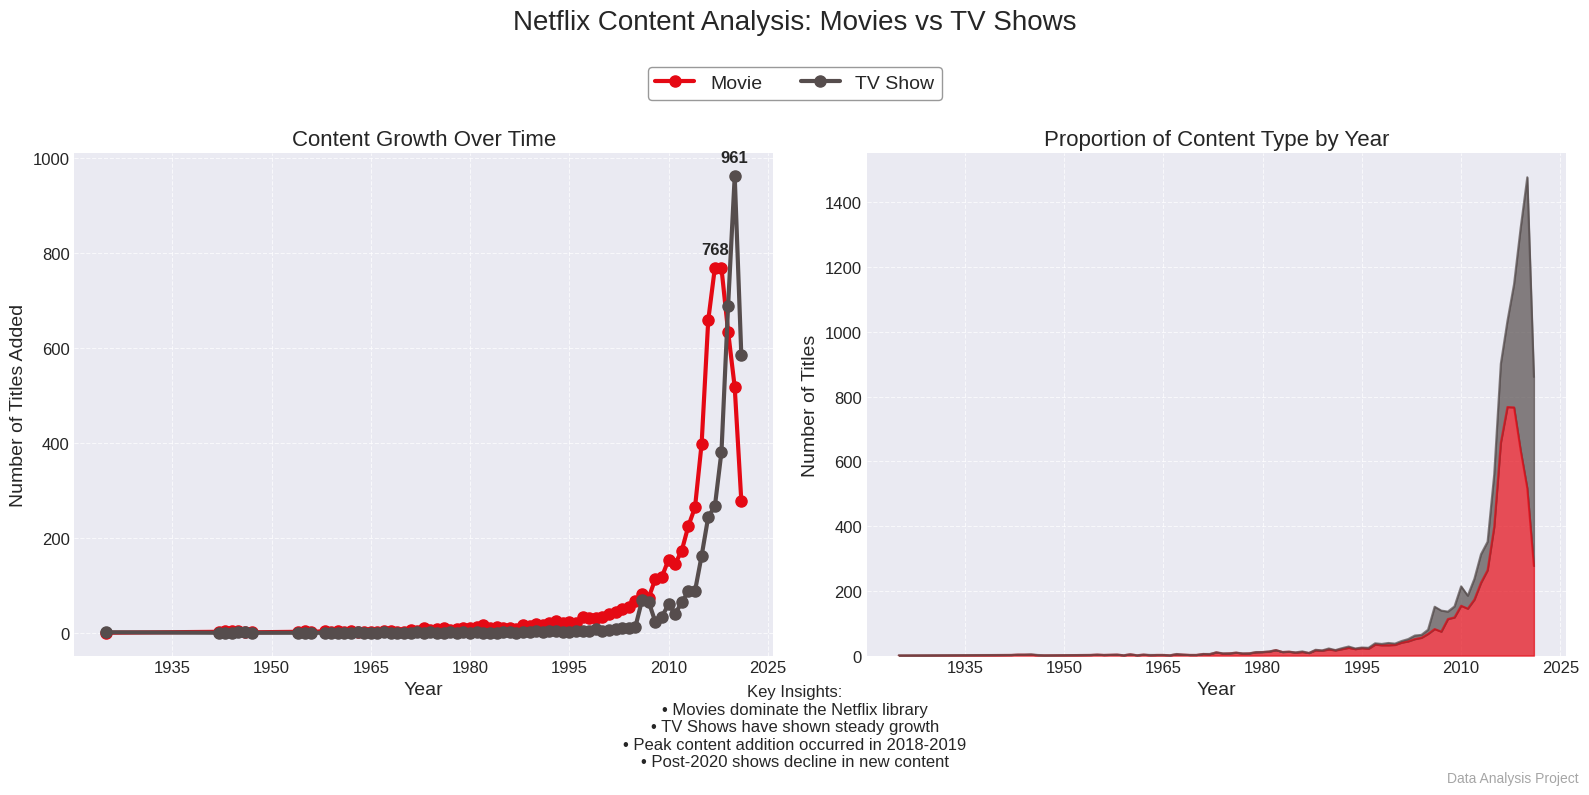

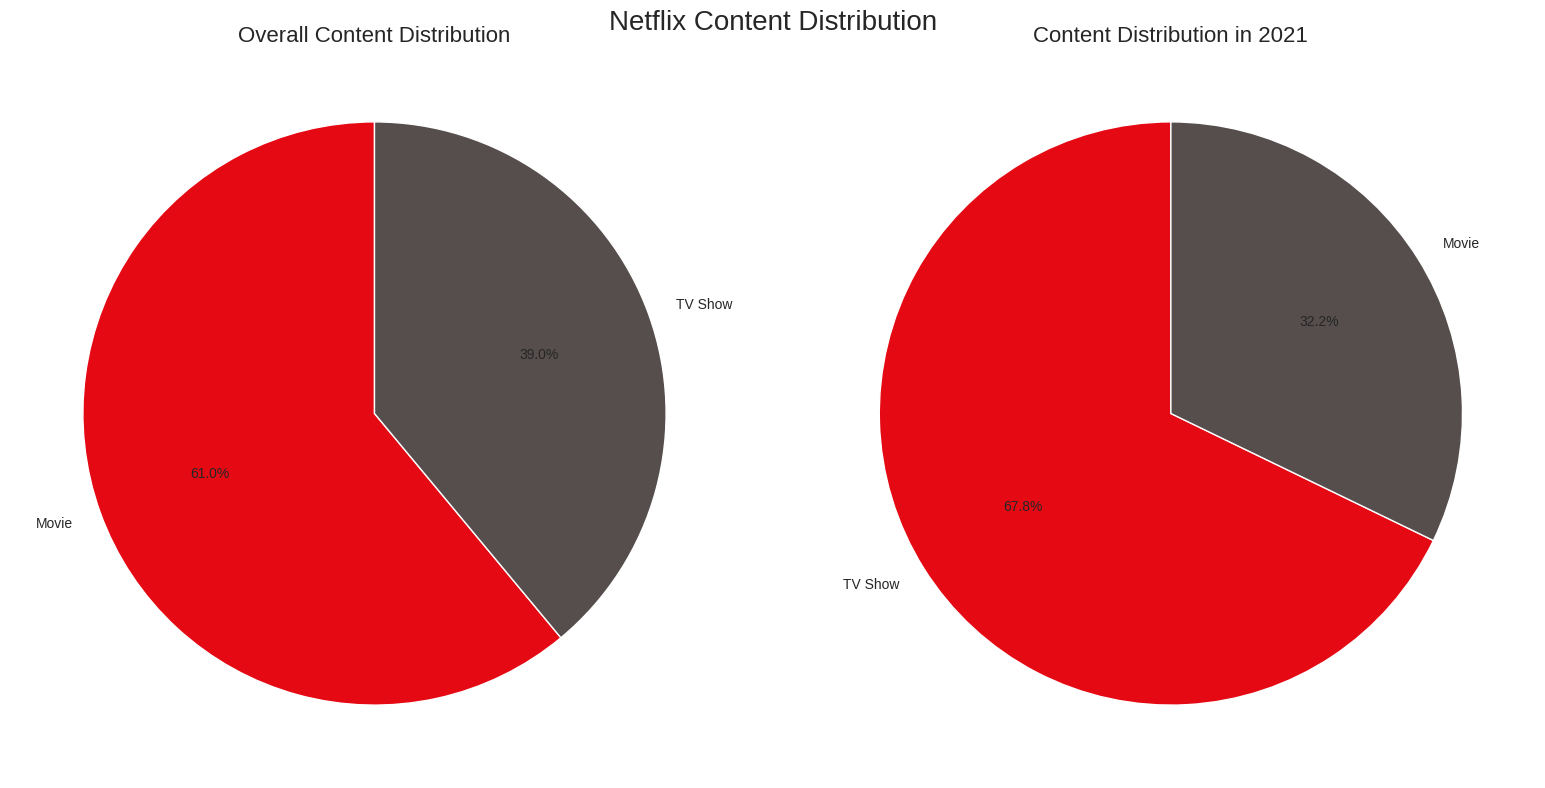

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import MaxNLocator
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Set the aesthetic style of the plots
plt.style.use('seaborn-v0_8-darkgrid')

# Load your data from the specific path
file_path = "/content/drive/My Drive/DATA 230/Sem Project/Trial 01"
df = pd.read_csv(file_path + '/netflix_show_with_scores.csv')

# Use your actual column names
year_column = 'release_year'
type_column = 'type'

# Count shows by type and year
show_counts = df.groupby([year_column, type_column]).size().reset_index(name='count')

# Create a pivot table for easier plotting
pivot_data = show_counts.pivot(index=year_column, columns=type_column, values='count').fillna(0)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Netflix Content Analysis: Movies vs TV Shows', fontsize=20, y=0.98)

# Set a custom color palette
colors = ['#E50914', '#564D4D']  # Netflix red and a dark gray

# Plot 1: Line chart with custom styling
pivot_data.plot(kind='line', ax=ax1, color=colors, linewidth=3, marker='o', markersize=8)
ax1.set_title('Content Growth Over Time', fontsize=16)
ax1.set_xlabel('Year', fontsize=14)
ax1.set_ylabel('Number of Titles Added', fontsize=14)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

# Annotate the highest points
for column in pivot_data.columns:
    max_idx = pivot_data[column].idxmax()
    max_val = pivot_data[column].max()
    ax1.annotate(f'{int(max_val)}',
                xy=(max_idx, max_val),
                xytext=(0, 10),
                textcoords='offset points',
                ha='center',
                fontsize=12,
                fontweight='bold')

# Plot 2: Stacked area chart showing proportion
pivot_data.plot(kind='area', stacked=True, ax=ax2, color=colors, alpha=0.7)
ax2.set_title('Proportion of Content Type by Year', fontsize=16)
ax2.set_xlabel('Year', fontsize=14)
ax2.set_ylabel('Number of Titles', fontsize=14)
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

# Add a text box with key insights
text_str = (
    "Key Insights:\n"
    "• Movies dominate the Netflix library\n"
    "• TV Shows have shown steady growth\n"
    "• Peak content addition occurred in 2018-2019\n"
    "• Post-2020 shows decline in new content"
)
props = dict(boxstyle='round', facecolor='white', alpha=0.7)
fig.text(0.5, 0.03, text_str, fontsize=12,
        verticalalignment='bottom', horizontalalignment='center',
        bbox=props)

# Customize the legend
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',
          bbox_to_anchor=(0.5, 0.92),
          ncol=2, fontsize=14, frameon=True,
          facecolor='white', edgecolor='gray')
ax1.get_legend().remove()
ax2.get_legend().remove()

# Add a watermark
fig.text(0.99, 0.01, 'Data Analysis Project', fontsize=10,
         color='gray', ha='right', va='bottom', alpha=0.7)

# Adjust layout
plt.tight_layout(rect=[0, 0.1, 1, 0.9])

# Save with high resolution for presentation
plt.savefig('netflix_content_analysis.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# Additional visualization option: Pie charts showing overall distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Netflix Content Distribution', fontsize=20, y=0.98)

# Overall distribution
overall_counts = df[type_column].value_counts()
ax1.pie(overall_counts, labels=overall_counts.index, autopct='%1.1f%%',
       colors=colors, startangle=90, wedgeprops={'edgecolor': 'w'})
ax1.set_title('Overall Content Distribution', fontsize=16)

# Distribution in the most recent year
latest_year = df[year_column].max()
recent_counts = df[df[year_column] == latest_year][type_column].value_counts()
ax2.pie(recent_counts, labels=recent_counts.index, autopct='%1.1f%%',
       colors=colors, startangle=90, wedgeprops={'edgecolor': 'w'})
ax2.set_title(f'Content Distribution in {latest_year}', fontsize=16)

plt.tight_layout()
plt.savefig('netflix_content_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

## EDIT 2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


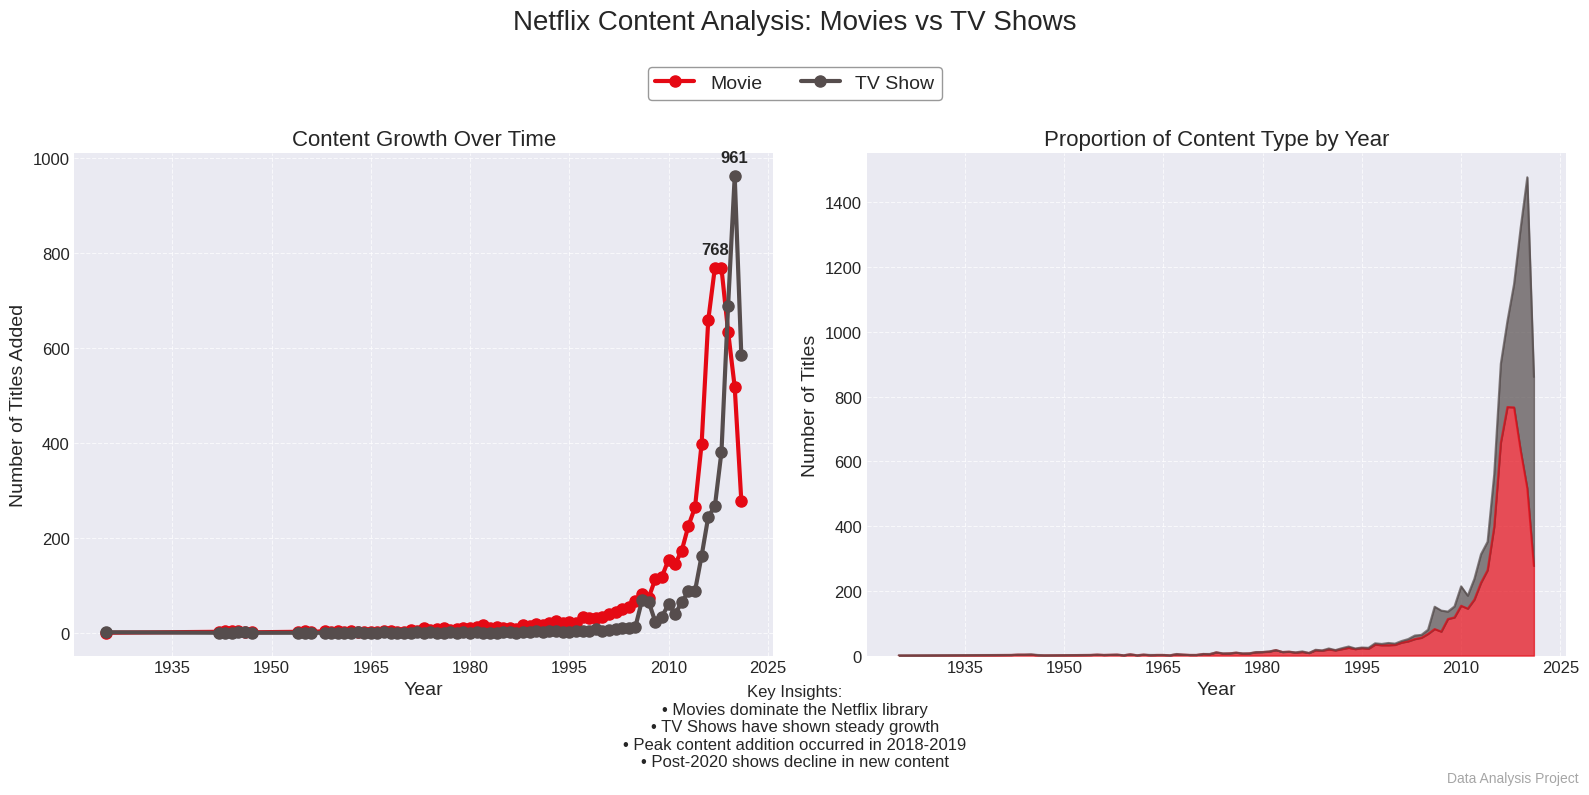

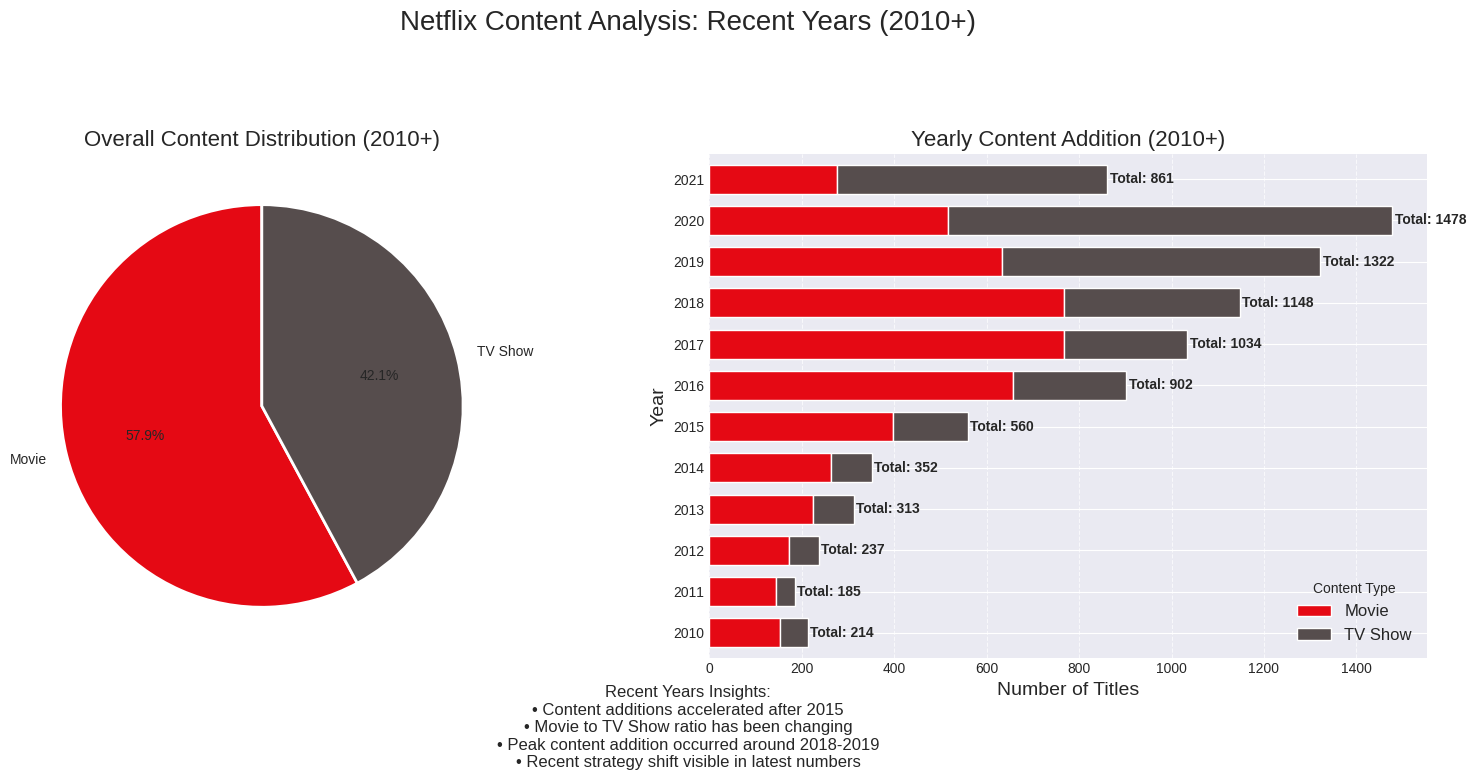

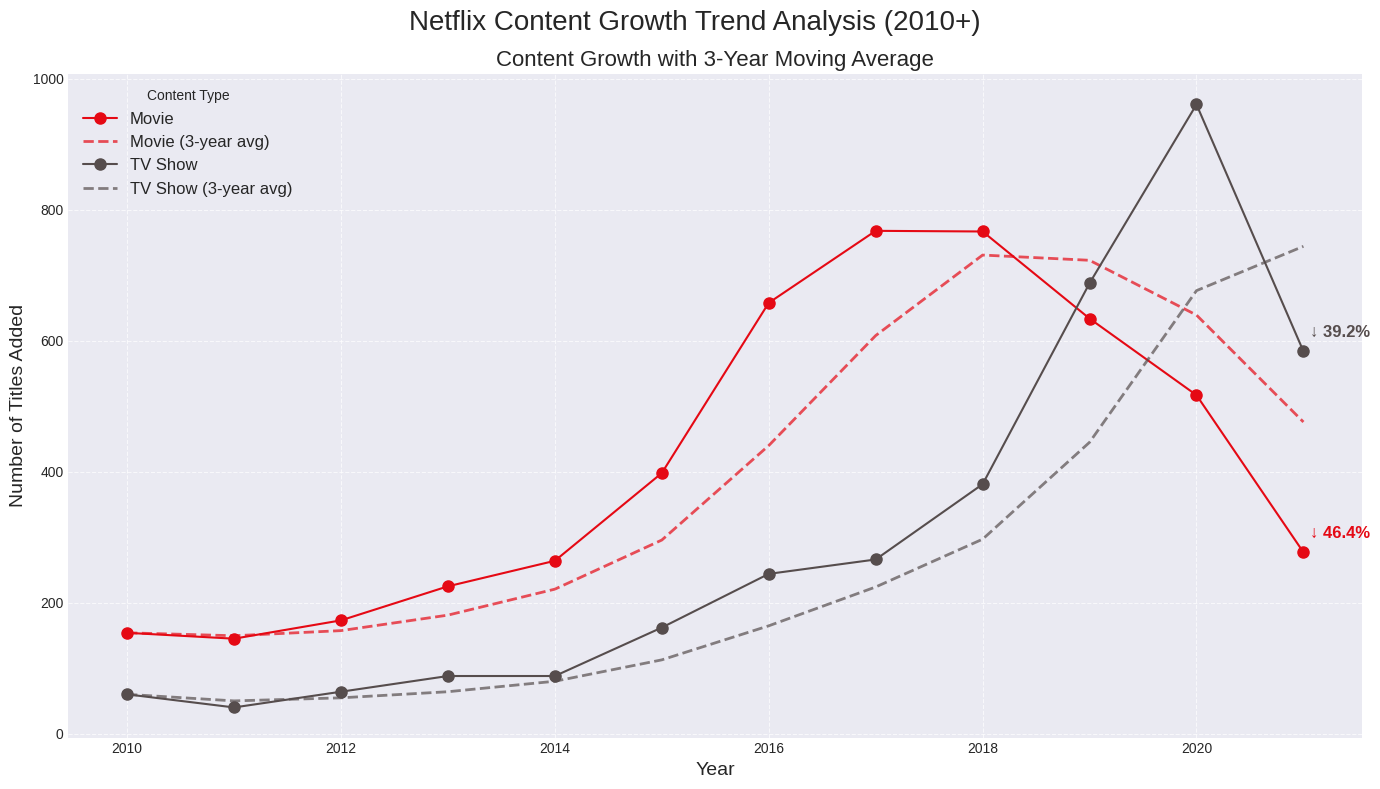

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import MaxNLocator
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Set the aesthetic style of the plots
plt.style.use('seaborn-v0_8-darkgrid')

# Load your data from the specific path
file_path = "/content/drive/My Drive/DATA 230/Sem Project/Trial 01"
df = pd.read_csv(file_path + '/netflix_show_with_scores.csv')

# Use your actual column names
year_column = 'release_year'
type_column = 'type'

# Count shows by type and year
show_counts = df.groupby([year_column, type_column]).size().reset_index(name='count')

# Create a pivot table for easier plotting
pivot_data = show_counts.pivot(index=year_column, columns=type_column, values='count').fillna(0)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Netflix Content Analysis: Movies vs TV Shows', fontsize=20, y=0.98)

# Set a custom color palette
colors = ['#E50914', '#564D4D']  # Netflix red and a dark gray

# Plot 1: Line chart with custom styling
pivot_data.plot(kind='line', ax=ax1, color=colors, linewidth=3, marker='o', markersize=8)
ax1.set_title('Content Growth Over Time', fontsize=16)
ax1.set_xlabel('Year', fontsize=14)
ax1.set_ylabel('Number of Titles Added', fontsize=14)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

# Annotate the highest points
for column in pivot_data.columns:
    max_idx = pivot_data[column].idxmax()
    max_val = pivot_data[column].max()
    ax1.annotate(f'{int(max_val)}',
                xy=(max_idx, max_val),
                xytext=(0, 10),
                textcoords='offset points',
                ha='center',
                fontsize=12,
                fontweight='bold')

# Plot 2: Stacked area chart showing proportion
pivot_data.plot(kind='area', stacked=True, ax=ax2, color=colors, alpha=0.7)
ax2.set_title('Proportion of Content Type by Year', fontsize=16)
ax2.set_xlabel('Year', fontsize=14)
ax2.set_ylabel('Number of Titles', fontsize=14)
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

# Add a text box with key insights
text_str = (
    "Key Insights:\n"
    "• Movies dominate the Netflix library\n"
    "• TV Shows have shown steady growth\n"
    "• Peak content addition occurred in 2018-2019\n"
    "• Post-2020 shows decline in new content"
)
props = dict(boxstyle='round', facecolor='white', alpha=0.7)
fig.text(0.5, 0.03, text_str, fontsize=12,
        verticalalignment='bottom', horizontalalignment='center',
        bbox=props)

# Customize the legend
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',
          bbox_to_anchor=(0.5, 0.92),
          ncol=2, fontsize=14, frameon=True,
          facecolor='white', edgecolor='gray')
ax1.get_legend().remove()
ax2.get_legend().remove()

# Add a watermark
fig.text(0.99, 0.01, 'Data Analysis Project', fontsize=10,
         color='gray', ha='right', va='bottom', alpha=0.7)

# Adjust layout
plt.tight_layout(rect=[0, 0.1, 1, 0.9])

# Save with high resolution for presentation
plt.savefig('netflix_content_analysis.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# Additional visualization: Recent years analysis (2010 onwards)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Netflix Content Analysis: Recent Years (2010+)', fontsize=20, y=0.98)

# Filter data for years 2010 and later
recent_df = df[df[year_column] >= 2010]

# Left plot: Pie chart showing overall distribution
overall_counts = recent_df[type_column].value_counts()
ax1.pie(overall_counts, labels=overall_counts.index, autopct='%1.1f%%',
       colors=colors, startangle=90, wedgeprops={'edgecolor': 'w', 'linewidth': 2})
ax1.set_title('Overall Content Distribution (2010+)', fontsize=16)

# Right plot: Horizontal bar chart showing yearly distribution
yearly_counts = recent_df.groupby([year_column, type_column]).size().unstack()
yearly_counts.plot(kind='barh', stacked=True, ax=ax2, color=colors, width=0.7)
ax2.set_title('Yearly Content Addition (2010+)', fontsize=16)
ax2.set_xlabel('Number of Titles', fontsize=14)
ax2.set_ylabel('Year', fontsize=14)
ax2.grid(True, linestyle='--', alpha=0.7, axis='x')
ax2.legend(title='Content Type', fontsize=12)

# Add data labels to the bars
for i, (idx, row) in enumerate(yearly_counts.iterrows()):
    total = row.sum()
    ax2.text(total + 5, i, f'Total: {int(total)}',
             va='center', ha='left', fontsize=10, fontweight='bold')

# Add a text box with insights about recent years
recent_years_text = (
    "Recent Years Insights:\n"
    "• Content additions accelerated after 2015\n"
    "• Movie to TV Show ratio has been changing\n"
    "• Peak content addition occurred around 2018-2019\n"
    "• Recent strategy shift visible in latest numbers"
)
props = dict(boxstyle='round', facecolor='white', alpha=0.7)
fig.text(0.5, 0.03, recent_years_text, fontsize=12,
        verticalalignment='bottom', horizontalalignment='center',
        bbox=props)

plt.tight_layout(rect=[0, 0.1, 1, 0.9])
plt.savefig('netflix_recent_years_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Third visualization: Trend analysis with moving average
plt.figure(figsize=(14, 8))
plt.suptitle('Netflix Content Growth Trend Analysis (2010+)', fontsize=20, y=0.98)

# Create a pivot table for easier plotting
pivot_recent = recent_df.groupby([year_column, type_column]).size().reset_index(name='count')
pivot_recent = pivot_recent.pivot(index=year_column, columns=type_column, values='count').fillna(0)

# Calculate 3-year moving averages
for col in pivot_recent.columns:
    ma_col = f"{col}_MA"
    pivot_recent[ma_col] = pivot_recent[col].rolling(window=3, min_periods=1).mean()

# Line chart with actual values and moving averages
for i, col in enumerate(pivot_recent.columns):
    if "_MA" not in col:
        # Main data points with markers
        plt.plot(pivot_recent.index, pivot_recent[col], marker='o', markersize=8,
                 color=colors[i], label=f"{col}")
        # Moving average as smooth line
        ma_col = f"{col}_MA"
        plt.plot(pivot_recent.index, pivot_recent[ma_col], linestyle='--',
                 color=colors[i], linewidth=2, alpha=0.7, label=f"{col} (3-year avg)")

plt.grid(True, linestyle='--', alpha=0.7)
plt.title('Content Growth with 3-Year Moving Average', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Titles Added', fontsize=14)
plt.legend(title='Content Type', fontsize=12)

# Add percentage change annotations for the most recent year
last_year = pivot_recent.index.max()
prev_year = last_year - 1
for col in pivot_recent.columns:
    if "_MA" not in col:
        current = pivot_recent.loc[last_year, col]
        previous = pivot_recent.loc[prev_year, col]
        pct_change = ((current - previous) / previous * 100) if previous > 0 else float('inf')

        if not np.isnan(pct_change) and not np.isinf(pct_change):
            direction = "↑" if pct_change >= 0 else "↓"
            plt.annotate(f"{direction} {abs(pct_change):.1f}%",
                        xy=(last_year, current),
                        xytext=(5, 10),
                        textcoords="offset points",
                        fontsize=12,
                        fontweight='bold',
                        color=colors[list(pivot_recent.columns).index(col) % len(colors)])

plt.tight_layout()
plt.savefig('netflix_trend_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## Rest

In [3]:



from google.colab import drive
drive.mount('/content/drive')

file_path = "/content/drive/My Drive/DATA 230/Sem Project/Trial 01"

# Load the two CSV files
# netflix_df = pd.read_csv(file_path + '/netflix_titles.csv')


Mounted at /content/drive


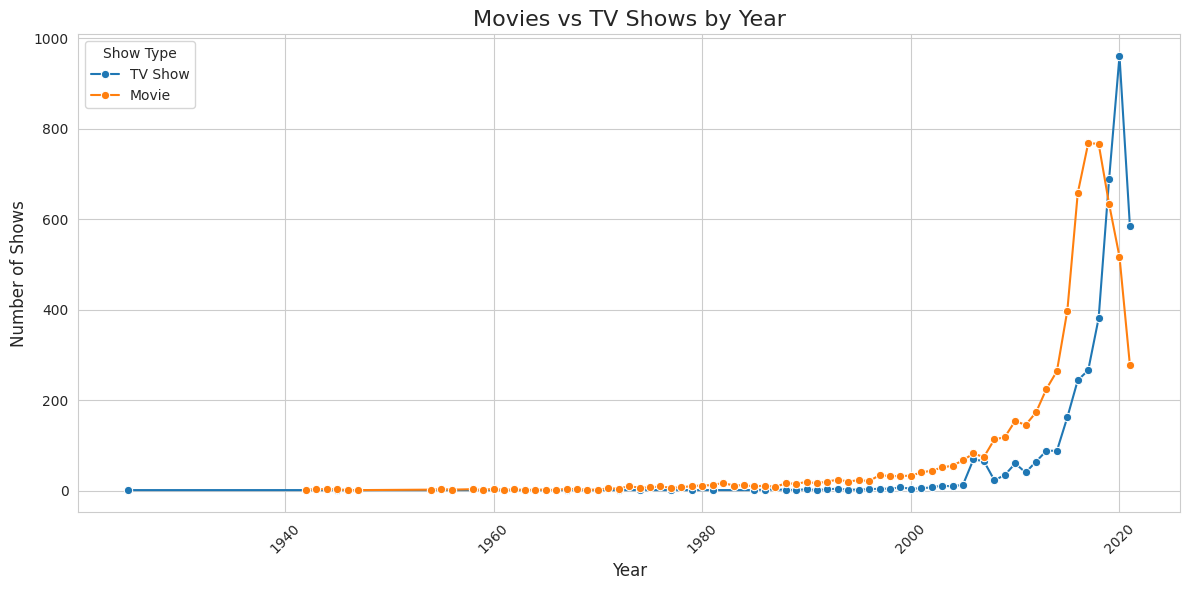

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your data is in a CSV file
df = pd.read_csv(file_path + '/netflix_show_with_scores.csv')

# # Count shows by type and year
# show_counts = df.groupby(['release_year', 'type']).size().reset_index(name='count')

# # Pivot the data for easier plotting
# pivot_data = show_counts.pivot(index='release_year', columns='type', values='count').fillna(0)

# # Create a visually appealing plot
# plt.figure(figsize=(12, 6))

# # Option 1: Line chart showing trends over time
# ax = pivot_data.plot(kind='line', marker='o')
# plt.title('Movies vs TV Shows by Year', fontsize=16)
# plt.xlabel('Year', fontsize=12)
# plt.ylabel('Count', fontsize=12)
# plt.grid(True, alpha=0.3)
# plt.legend(title='Show Type')

# # Option 2: Stacked bar chart
# # pivot_data.plot(kind='bar', stacked=True)
# # plt.title('Movies vs TV Shows by Year', fontsize=16)
# # plt.xlabel('Year', fontsize=12)
# # plt.ylabel('Count', fontsize=12)
# # plt.xticks(rotation=45)
# # plt.legend(title='Show Type')

# plt.tight_layout()
# plt.show()

# # Option 3: Using Seaborn for a more stylish visualization
# plt.figure(figsize=(12, 10))
# sns.set_style("whitegrid")
# sns_plot = sns.lineplot(data=df, x='release_year', y='count', hue='type',
#                         marker='o', dashes=False)
# plt.title('Movies vs TV Shows by Year', fontsize=16)
# plt.xlabel('Year', fontsize=12)
# plt.ylabel('Count', fontsize=12)
# plt.xticks(rotation=45)
# plt.legend(title='Show Type')
# plt.tight_layout()
# plt.show()

# Use your actual column names
year_column = 'release_year'
type_column = 'type'

# Count shows by type and year
show_counts = df.groupby([year_column, type_column]).size().reset_index(name='count')

# Now create the visualization with the correct reference to 'count'
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# This is the key fix - using the show_counts DataFrame which has our calculated 'count' column
sns_plot = sns.lineplot(
    data=show_counts,  # Use show_counts, not df
    x=year_column,
    y='count',  # This refers to the column we created in the groupby operation
    hue=type_column,
    marker='o',
    dashes=False
)

plt.title('Movies vs TV Shows by Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Shows', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Show Type')
plt.tight_layout()
plt.show()

## Final for 3.A

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<Figure size 1400x800 with 0 Axes>

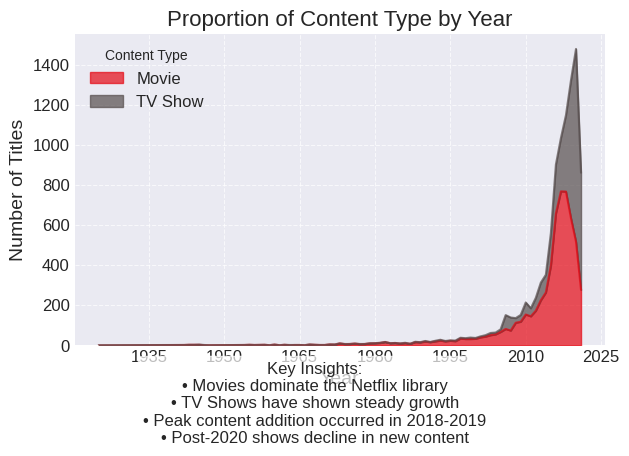

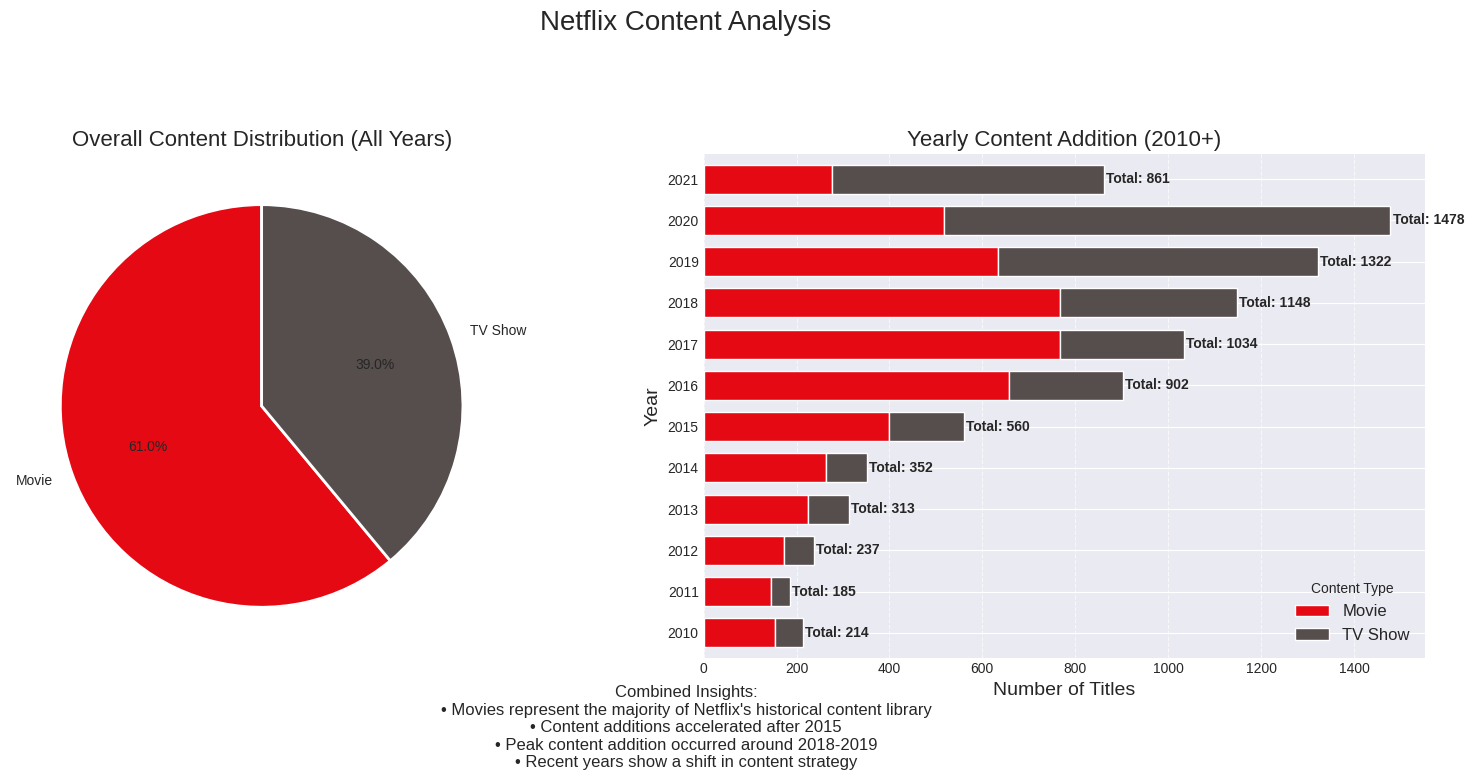

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Set the aesthetic style of the plots
plt.style.use('seaborn-v0_8-darkgrid')

# Load your data from the specific path
file_path = "/content/drive/My Drive/DATA 230/Sem Project/Trial 01"
df = pd.read_csv(file_path + '/netflix_show_with_scores.csv')

# Use your actual column names
year_column = 'release_year'
type_column = 'type'

# Count shows by type and year
show_counts = df.groupby([year_column, type_column]).size().reset_index(name='count')

# Create a pivot table for easier plotting
pivot_data = show_counts.pivot(index=year_column, columns=type_column, values='count').fillna(0)

# Set a custom color palette
colors = ['#E50914', '#564D4D']  # Netflix red and a dark gray

# Visualization 1: Stacked area chart showing proportion of content by year
plt.figure(figsize=(14, 8))
pivot_data.plot(kind='area', stacked=True, color=colors, alpha=0.7)
plt.title('Proportion of Content Type by Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Titles', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(title='Content Type', fontsize=12)

# Add a text box with key insights
text_str = (
    "Key Insights:\n"
    "• Movies dominate the Netflix library\n"
    "• TV Shows have shown steady growth\n"
    "• Peak content addition occurred in 2018-2019\n"
    "• Post-2020 shows decline in new content"
)
props = dict(boxstyle='round', facecolor='white', alpha=0.7)
plt.gcf().text(0.5, 0.01, text_str, fontsize=12,
        verticalalignment='bottom', horizontalalignment='center',
        bbox=props)

plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.savefig('netflix_content_proportion.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualization 2: Pie chart (all data) + Yearly content addition
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Netflix Content Analysis', fontsize=20, y=0.98)

# Left plot: Pie chart showing overall distribution (all data)
overall_counts = df[type_column].value_counts()
ax1.pie(overall_counts, labels=overall_counts.index, autopct='%1.1f%%',
       colors=colors, startangle=90, wedgeprops={'edgecolor': 'w', 'linewidth': 2})
ax1.set_title('Overall Content Distribution (All Years)', fontsize=16)

# Right plot: Horizontal bar chart showing yearly distribution (for 2010+)
recent_df = df[df[year_column] >= 2010]
yearly_counts = recent_df.groupby([year_column, type_column]).size().unstack()
yearly_counts.plot(kind='barh', stacked=True, ax=ax2, color=colors, width=0.7)
ax2.set_title('Yearly Content Addition (2010+)', fontsize=16)
ax2.set_xlabel('Number of Titles', fontsize=14)
ax2.set_ylabel('Year', fontsize=14)
ax2.grid(True, linestyle='--', alpha=0.7, axis='x')
ax2.legend(title='Content Type', fontsize=12)

# Add data labels to the bars
for i, (idx, row) in enumerate(yearly_counts.iterrows()):
    total = row.sum()
    ax2.text(total + 5, i, f'Total: {int(total)}',
             va='center', ha='left', fontsize=10, fontweight='bold')

# Add a text box with insights
combined_insights = (
    "Combined Insights:\n"
    "• Movies represent the majority of Netflix's historical content library\n"
    "• Content additions accelerated after 2015\n"
    "• Peak content addition occurred around 2018-2019\n"
    "• Recent years show a shift in content strategy"
)
props = dict(boxstyle='round', facecolor='white', alpha=0.7)
fig.text(0.5, 0.03, combined_insights, fontsize=12,
        verticalalignment='bottom', horizontalalignment='center',
        bbox=props)

plt.tight_layout(rect=[0, 0.1, 1, 0.9])
plt.savefig('netflix_pie_yearly.png', dpi=300, bbox_inches='tight')
plt.show()

# For 3B Most Popular Genres

## Test 01

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


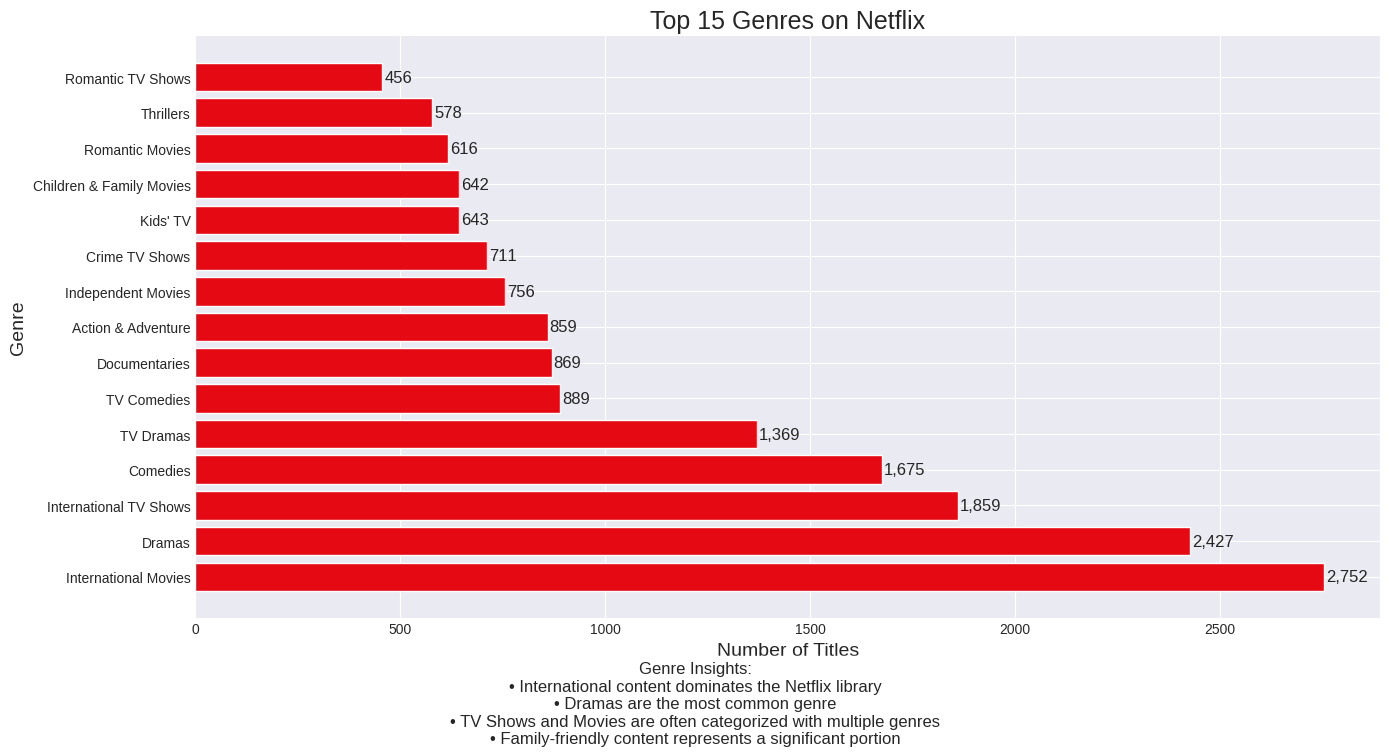

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Set the aesthetic style of the plots
plt.style.use('seaborn-v0_8-darkgrid')

# Load your data from the specific path
file_path = "/content/drive/My Drive/DATA 230/Sem Project/Trial 01"
df = pd.read_csv(file_path + '/netflix_show_with_scores.csv')

# Process the listed_in column to extract all genres
all_genres = []
for genres in df['listed_in']:
    # Split the genre string by comma and strip whitespace
    if isinstance(genres, str):  # Check if it's a string (not NaN)
        genre_list = [genre.strip() for genre in genres.split(',')]
        all_genres.extend(genre_list)

# Count genre frequencies
genre_counts = Counter(all_genres)

# Get the top 15 genres
top_genres = pd.DataFrame(genre_counts.most_common(15), columns=['Genre', 'Count'])

# Create a bar chart
plt.figure(figsize=(14, 8))

# Set Netflix color scheme
colors = ['#E50914']  # Netflix red
bar_color = colors[0]

# Create horizontal bar chart
bars = plt.barh(top_genres['Genre'], top_genres['Count'], color=bar_color)

# Add a title and labels
plt.title('Top 15 Genres on Netflix', fontsize=18)
plt.xlabel('Number of Titles', fontsize=14)
plt.ylabel('Genre', fontsize=14)

# Remove the top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add the count labels to the bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 5, bar.get_y() + bar.get_height()/2,
             f'{width:,}',
             ha='left', va='center', fontsize=12)

# Add a text box with insights
insights = (
    "Genre Insights:\n"
    "• International content dominates the Netflix library\n"
    "• Dramas are the most common genre\n"
    "• TV Shows and Movies are often categorized with multiple genres\n"
    "• Family-friendly content represents a significant portion"
)
props = dict(boxstyle='round', facecolor='white', alpha=0.7)
plt.gcf().text(0.5, 0.01, insights, fontsize=12,
               verticalalignment='bottom', horizontalalignment='center',
               bbox=props)

# Adjust layout
plt.tight_layout(rect=[0, 0.1, 1, 0.95])

# Save the figure
plt.savefig('netflix_top_genres.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

## Test 02 Final

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


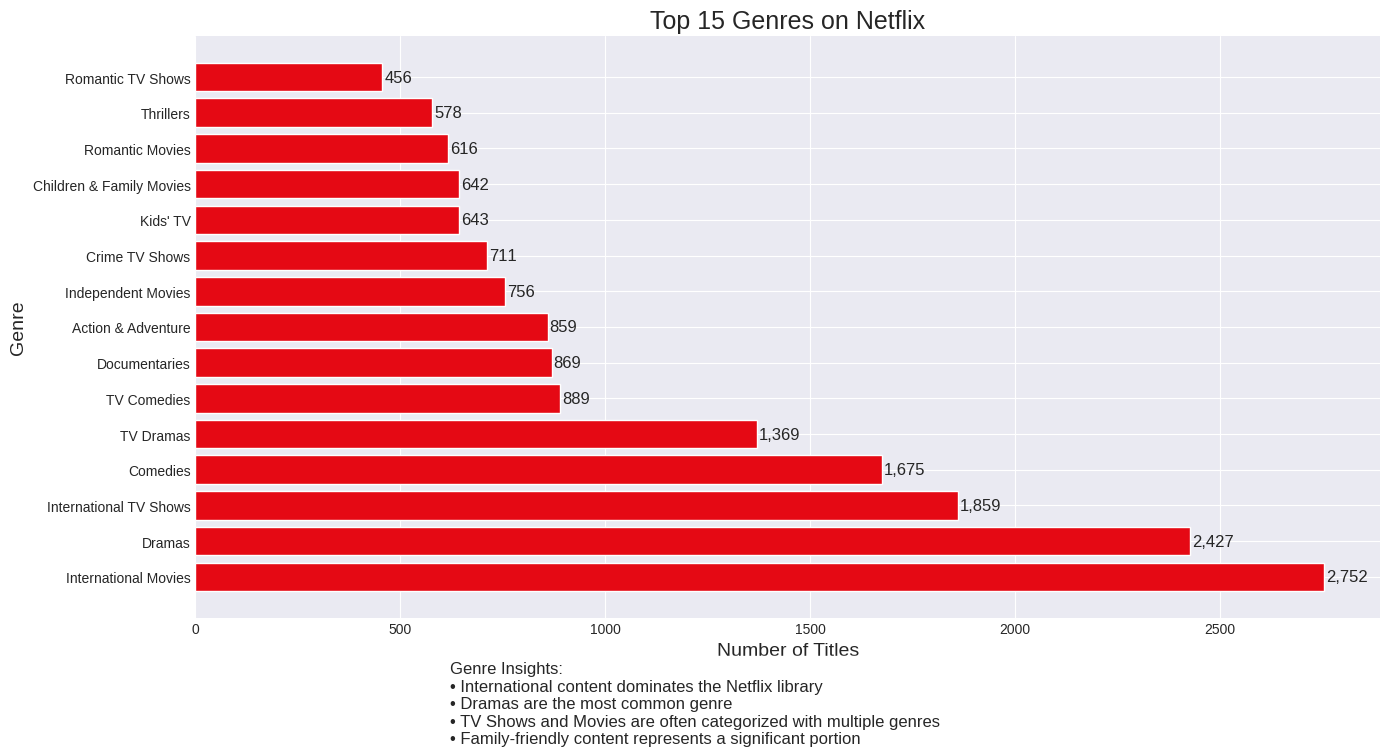

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Set the aesthetic style of the plots
plt.style.use('seaborn-v0_8-darkgrid')

# Load your data from the specific path
file_path = "/content/drive/My Drive/DATA 230/Sem Project/Trial 01"
df = pd.read_csv(file_path + '/netflix_show_with_scores.csv')

# Process the listed_in column to extract all genres
all_genres = []
for genres in df['listed_in']:
    # Split the genre string by comma and strip whitespace
    if isinstance(genres, str):  # Check if it's a string (not NaN)
        genre_list = [genre.strip() for genre in genres.split(',')]
        all_genres.extend(genre_list)

# Count genre frequencies
genre_counts = Counter(all_genres)

# Get the top 15 genres
top_genres = pd.DataFrame(genre_counts.most_common(15), columns=['Genre', 'Count'])

# Create a bar chart
plt.figure(figsize=(14, 8))

# Set Netflix color scheme
colors = ['#E50914']  # Netflix red
bar_color = colors[0]

# Create horizontal bar chart
bars = plt.barh(top_genres['Genre'], top_genres['Count'], color=bar_color)

# Add a title and labels
plt.title('Top 15 Genres on Netflix', fontsize=18, ha='center')
plt.xlabel('Number of Titles', fontsize=14)
plt.ylabel('Genre', fontsize=14)

# Remove the top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add the count labels to the bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 5, bar.get_y() + bar.get_height()/2,
             f'{width:,}',
             ha='left', va='center', fontsize=12)

# Add a text box with insights
insights = (
    "Genre Insights:\n"
    "• International content dominates the Netflix library\n"
    "• Dramas are the most common genre\n"
    "• TV Shows and Movies are often categorized with multiple genres\n"
    "• Family-friendly content represents a significant portion"
)
props = dict(boxstyle='round', facecolor='white', alpha=0.7)

# Position the text box at the bottom center, but with left-aligned text
fig = plt.gcf()
fig.text(0.5, 0.01, insights, fontsize=12,
         verticalalignment='bottom', horizontalalignment='center',
         bbox=props, multialignment='left')

# Adjust layout
plt.tight_layout(rect=[0, 0.1, 1, 0.95])

# Save the figure
plt.savefig('netflix_top_genres.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


## Test 03 Final

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


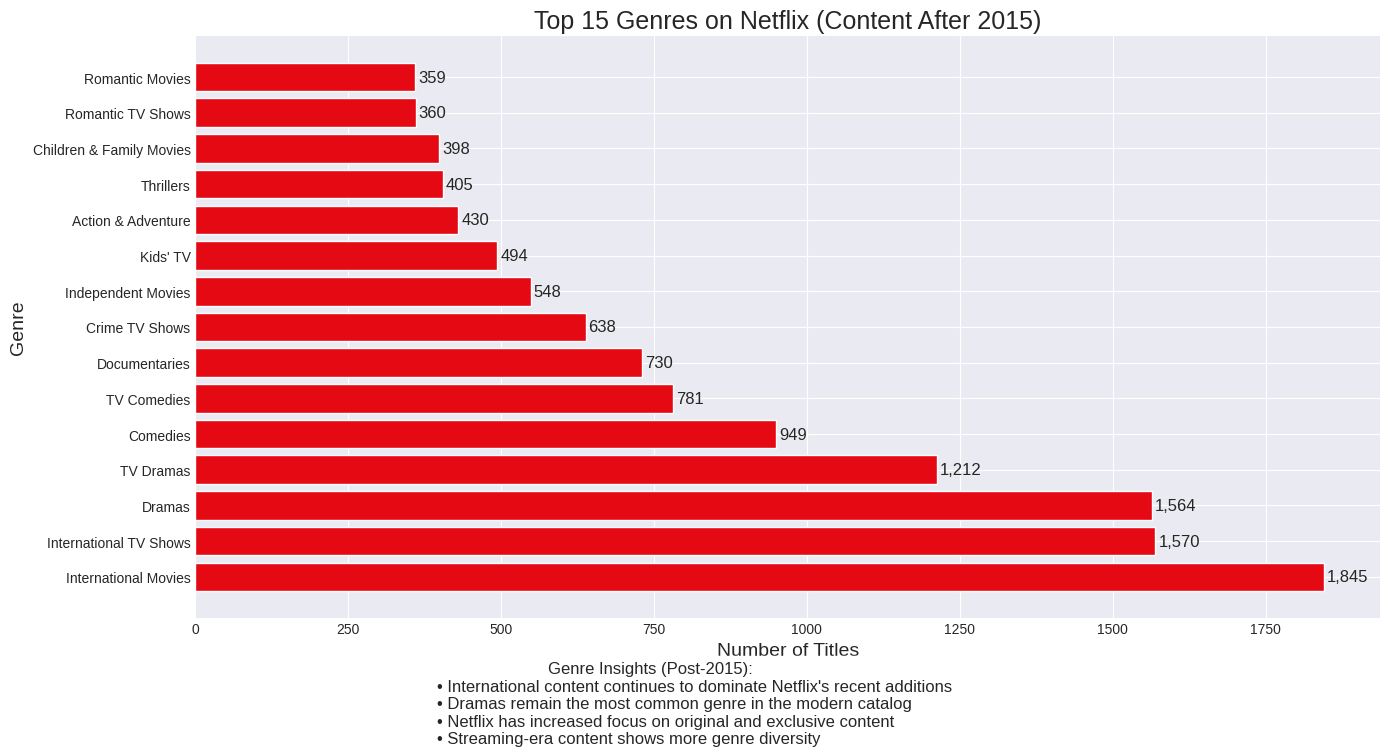

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Set the aesthetic style of the plots
plt.style.use('seaborn-v0_8-darkgrid')

# Load your data from the specific path
file_path = "/content/drive/My Drive/DATA 230/Sem Project/Trial 01"
df = pd.read_csv(file_path + '/netflix_show_with_scores.csv')

# Filter data for content released after 2010
df_recent = df[df['release_year'] >= 2015]

# Process the listed_in column to extract all genres for recent content
all_genres = []
for genres in df_recent['listed_in']:
    # Split the genre string by comma and strip whitespace
    if isinstance(genres, str):  # Check if it's a string (not NaN)
        genre_list = [genre.strip() for genre in genres.split(',')]
        all_genres.extend(genre_list)

# Count genre frequencies
genre_counts = Counter(all_genres)

# Get the top 15 genres
top_genres = pd.DataFrame(genre_counts.most_common(15), columns=['Genre', 'Count'])

# Create a bar chart
plt.figure(figsize=(14, 8))

# Set Netflix color scheme
colors = ['#E50914']  # Netflix red
bar_color = colors[0]

# Create horizontal bar chart
bars = plt.barh(top_genres['Genre'], top_genres['Count'], color=bar_color)

# Add a title and labels
plt.title('Top 15 Genres on Netflix (Content After 2015)', fontsize=18, ha='center')
plt.xlabel('Number of Titles', fontsize=14)
plt.ylabel('Genre', fontsize=14)

# Remove the top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add the count labels to the bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 5, bar.get_y() + bar.get_height()/2,
             f'{width:,}',
             ha='left', va='center', fontsize=12)

# Add a text box with insights
insights = (
    " "
    "                       Genre Insights (Post-2015):\n"
    "• International content continues to dominate Netflix's recent additions\n"
    "• Dramas remain the most common genre in the modern catalog\n"
    "• Netflix has increased focus on original and exclusive content\n"
    "• Streaming-era content shows more genre diversity"
)
props = dict(boxstyle='round', facecolor='white', alpha=0.7)

# Position the text box at the bottom center, but with left-aligned text
fig = plt.gcf()
fig.text(0.5, 0.01, insights, fontsize=12,
         verticalalignment='bottom', horizontalalignment='center',
         bbox=props, multialignment='left')

# Adjust layout
plt.tight_layout(rect=[0, 0.1, 1, 0.95])

# Save the figure
plt.savefig('netflix_top_genres_after_2015.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

# 3C Scatterplot for Rating and Popularity Trends

## Test 01

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


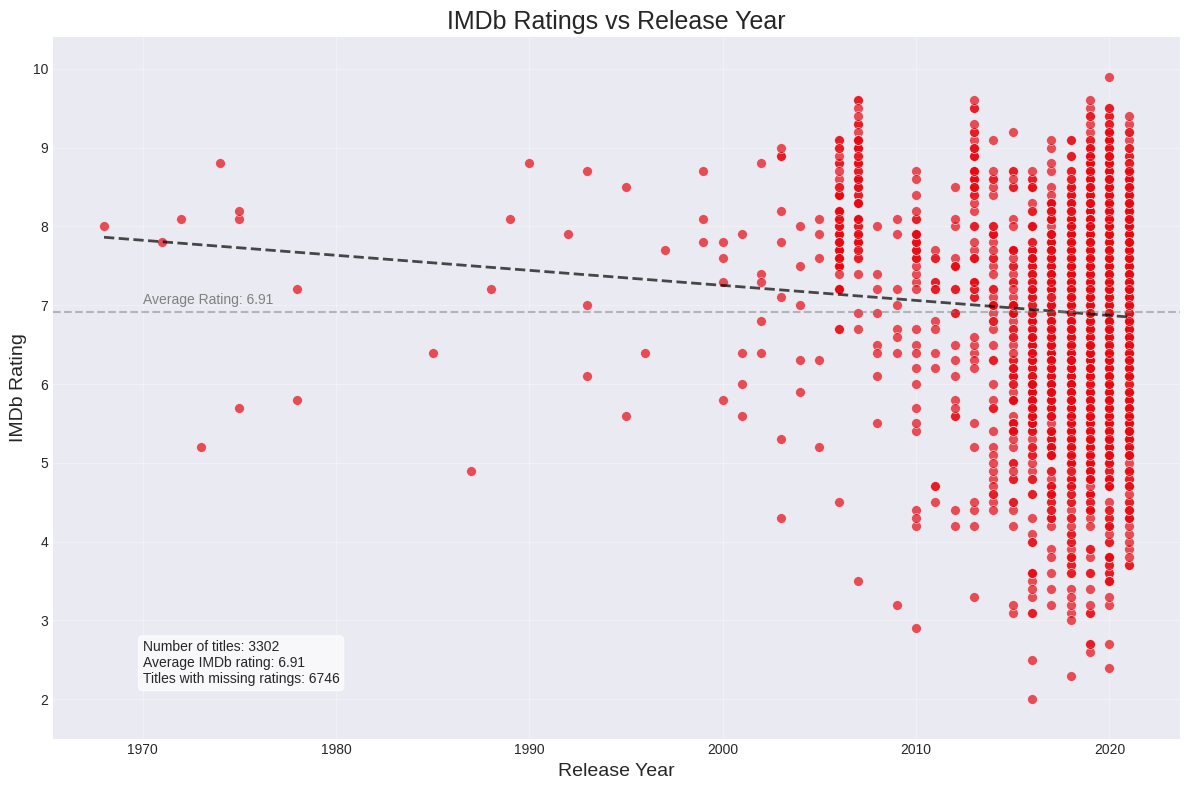

Correlation between release year and IMDb rating: -0.073
Earliest release year: 1968
Latest release year: 2021
Highest rated title: bojack horseman (9.9)
Lowest rated title: hajwala: the missing engine (2.0)


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from google.colab import drive

# Mount Google Drive (if using Colab)
drive.mount('/content/drive')

# Set the aesthetic style of the plots
plt.style.use('seaborn-v0_8-darkgrid')

# Load your data from the specific path
file_path = "/content/drive/My Drive/DATA 230/Sem Project/Trial 01"
df = pd.read_csv(file_path + '/netflix_show_with_scores.csv')

# Convert 'scores' column to numeric values, errors will be converted to NaN
df['scores'] = pd.to_numeric(df['scores'], errors='coerce')

# Clean data by dropping NaN values in scores
df_clean = df.dropna(subset=['scores'])

# Create a figure with appropriate size
plt.figure(figsize=(12, 8))

# Create scatter plot
plt.scatter(
    df_clean['release_year'],
    df_clean['scores'],
    alpha=0.7,                # Transparency of points
    c='#E50914',              # Netflix red color
    edgecolors='white',       # White edge around points
    s=50,                     # Size of points
    linewidths=0.5            # Width of the white edge
)

# Add a trend line to show the overall pattern
z = np.polyfit(df_clean['release_year'], df_clean['scores'], 1)
p = np.poly1d(z)
x_range = np.linspace(df_clean['release_year'].min(), df_clean['release_year'].max(), 100)
plt.plot(x_range, p(x_range), 'k--', alpha=0.7, linewidth=2)

# Add title and labels
plt.title('IMDb Ratings vs Release Year', fontsize=18)
plt.xlabel('Release Year', fontsize=14)
plt.ylabel('IMDb Rating', fontsize=14)

# Set y-axis limits to better display the ratings range
plt.ylim(df_clean['scores'].min() - 0.5, df_clean['scores'].max() + 0.5)

# Add a horizontal line for the average rating
avg_rating = df_clean['scores'].mean()
plt.axhline(y=avg_rating, color='gray', linestyle='--', alpha=0.5)
plt.text(
    df_clean['release_year'].min() + 2,
    avg_rating + 0.1,
    f'Average Rating: {avg_rating:.2f}',
    fontsize=10,
    color='gray'
)

# Remove unnecessary spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Add a brief summary of the visualization
stats_text = (
    f"Number of titles: {len(df_clean)}\n"
    f"Average IMDb rating: {avg_rating:.2f}\n"
    f"Titles with missing ratings: {len(df) - len(df_clean)}"
)
props = dict(boxstyle='round', facecolor='white', alpha=0.7)
plt.text(
    df_clean['release_year'].min() + 2,
    df_clean['scores'].min() + 0.2,
    stats_text,
    fontsize=10,
    bbox=props
)

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig('imdb_ratings_by_year.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

# Print some basic statistics
print(f"Correlation between release year and IMDb rating: {df_clean['release_year'].corr(df_clean['scores']):.3f}")
print(f"Earliest release year: {df_clean['release_year'].min()}")
print(f"Latest release year: {df_clean['release_year'].max()}")
print(f"Highest rated title: {df_clean.loc[df_clean['scores'].idxmax()]['title']} ({df_clean['scores'].max()})")
print(f"Lowest rated title: {df_clean.loc[df_clean['scores'].idxmin()]['title']} ({df_clean['scores'].min()})")

## Test 02

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


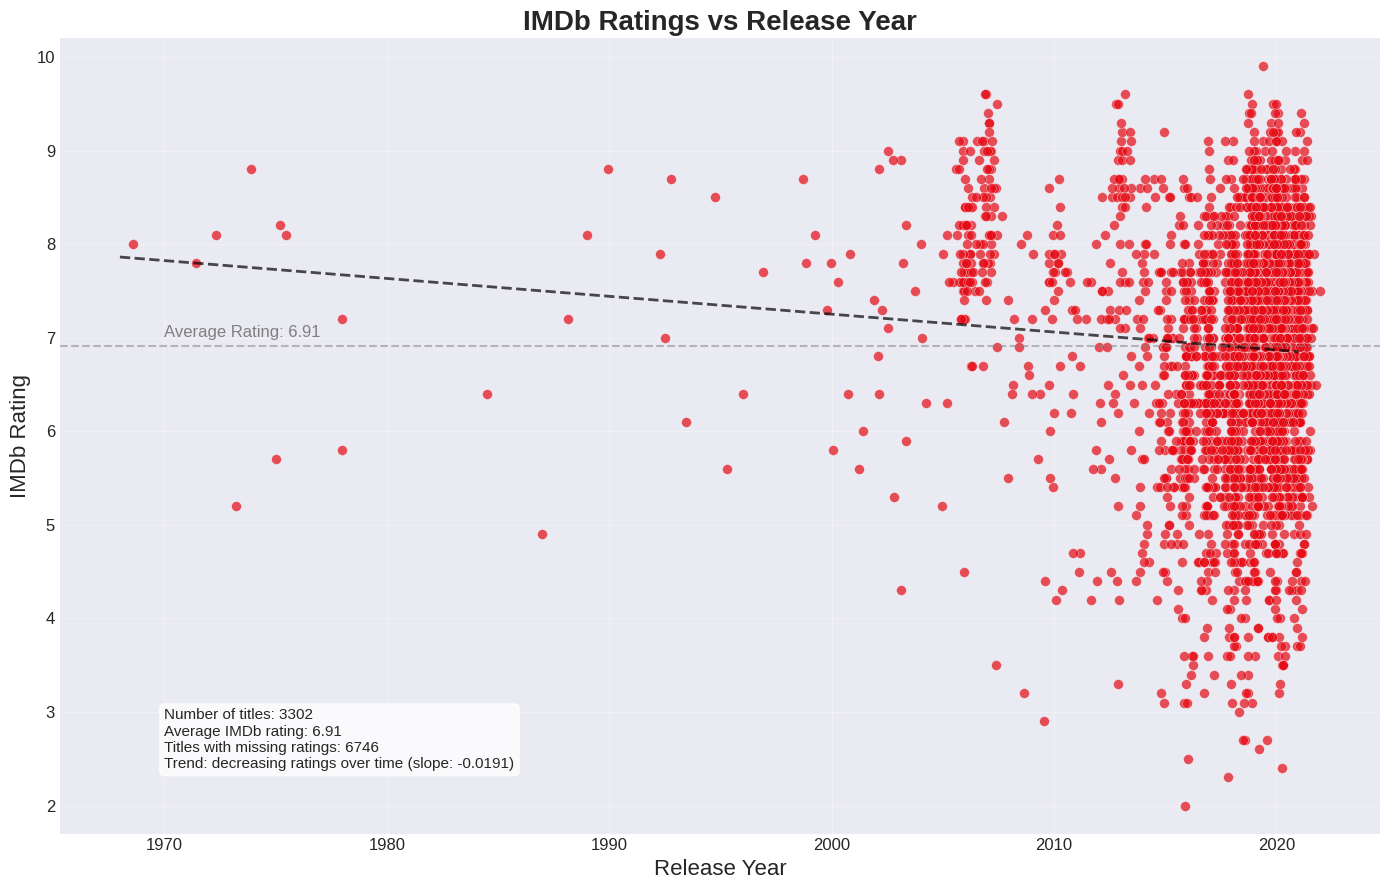

Correlation between release year and IMDb rating: -0.073
Titles by decade:
1960s: 1 titles
1970s: 9 titles
1980s: 4 titles
1990s: 12 titles
2000s: 165 titles
2010s: 1631 titles
2020s: 1480 titles


<ipython-input-26-e6e57cfdc18e>:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['decade'] = (df_clean['release_year'] // 10) * 10


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from google.colab import drive

# Mount Google Drive (if using Colab)
drive.mount('/content/drive')

# Set the aesthetic style of the plots
plt.style.use('seaborn-v0_8-darkgrid')

# Load your data from the specific path
file_path = "/content/drive/My Drive/DATA 230/Sem Project/Trial 01"
df = pd.read_csv(file_path + '/netflix_show_with_scores.csv')

# Convert 'scores' column to numeric values, errors will be converted to NaN
df['scores'] = pd.to_numeric(df['scores'], errors='coerce')

# Clean data by dropping NaN values in scores
df_clean = df.dropna(subset=['scores'])

# Create a figure with appropriate size
plt.figure(figsize=(14, 9))

# Add jitter to the release_year to avoid vertical lines
# Use numpy's random seed for reproducibility
np.random.seed(42)
jitter = np.random.normal(0, 0.25, size=len(df_clean))
x = df_clean['release_year'].values
y = df_clean['scores'].values
x_jittered = x + jitter

# Create scatter plot with default coloring first
scatter = plt.scatter(
    x_jittered,
    y,
    c='#E50914',  # Netflix red
    alpha=0.7,
    s=50,
    edgecolors='white',
    linewidths=0.3
)

# Add a trend line to show the overall pattern
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
x_range = np.linspace(min(x), max(x), 100)
plt.plot(x_range, p(x_range), 'k--', alpha=0.7, linewidth=2)

# Calculate slope and intercept for annotation
slope, intercept = z
trend_direction = "decreasing" if slope < 0 else "increasing"

# Add title and labels
plt.title('IMDb Ratings vs Release Year', fontsize=20, fontweight='bold')
plt.xlabel('Release Year', fontsize=16)
plt.ylabel('IMDb Rating', fontsize=16)

# Set y-axis limits to better display the ratings range
plt.ylim(min(y) - 0.3, max(y) + 0.3)

# Add a horizontal line for the average rating
avg_rating = y.mean()
plt.axhline(y=avg_rating, color='gray', linestyle='--', alpha=0.5)
plt.text(
    min(x) + 2,
    avg_rating + 0.1,
    f'Average Rating: {avg_rating:.2f}',
    fontsize=12,
    color='gray'
)

# Remove unnecessary spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Add a brief summary of the visualization
stats_text = (
    f"Number of titles: {len(df_clean)}\n"
    f"Average IMDb rating: {avg_rating:.2f}\n"
    f"Titles with missing ratings: {len(df) - len(df_clean)}\n"
    f"Trend: {trend_direction} ratings over time (slope: {slope:.4f})"
)
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.text(
    min(x) + 2,
    min(y) + 0.4,
    stats_text,
    fontsize=11,
    bbox=props
)

# Adjust tick sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig('imdb_ratings_by_year_fixed.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

# Print additional insights
print(f"Correlation between release year and IMDb rating: {np.corrcoef(x, y)[0,1]:.3f}")
print(f"Titles by decade:")
df_clean['decade'] = (df_clean['release_year'] // 10) * 10
decade_counts = df_clean['decade'].value_counts().sort_index()
for decade, count in decade_counts.items():
    print(f"{decade}s: {count} titles")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


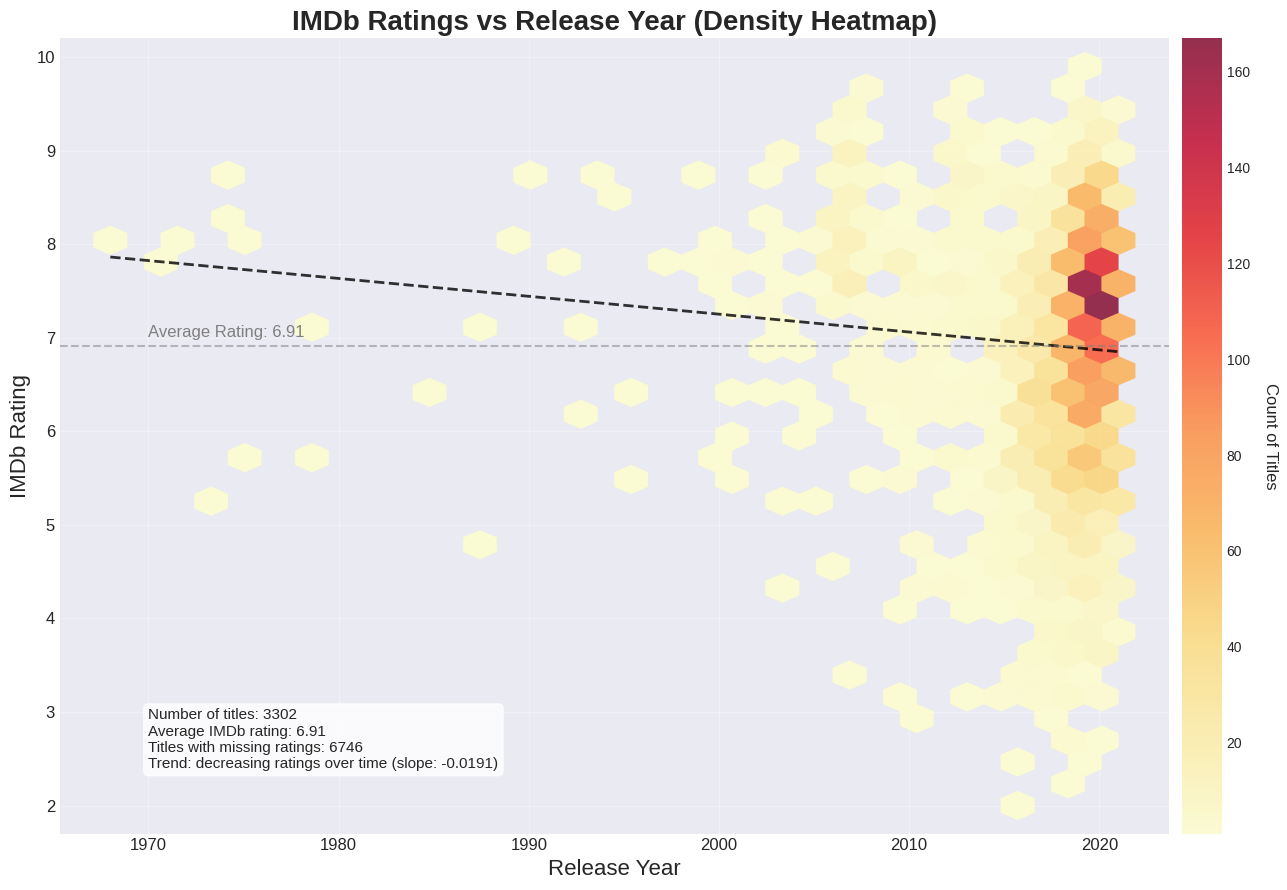

Correlation between release year and IMDb rating: -0.073
Titles by decade:
1960s: 1 titles
1970s: 9 titles
1980s: 4 titles
1990s: 12 titles
2000s: 165 titles
2010s: 1631 titles
2020s: 1480 titles


<ipython-input-27-d551ca0456a0>:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['decade'] = (df_clean['release_year'] // 10) * 10


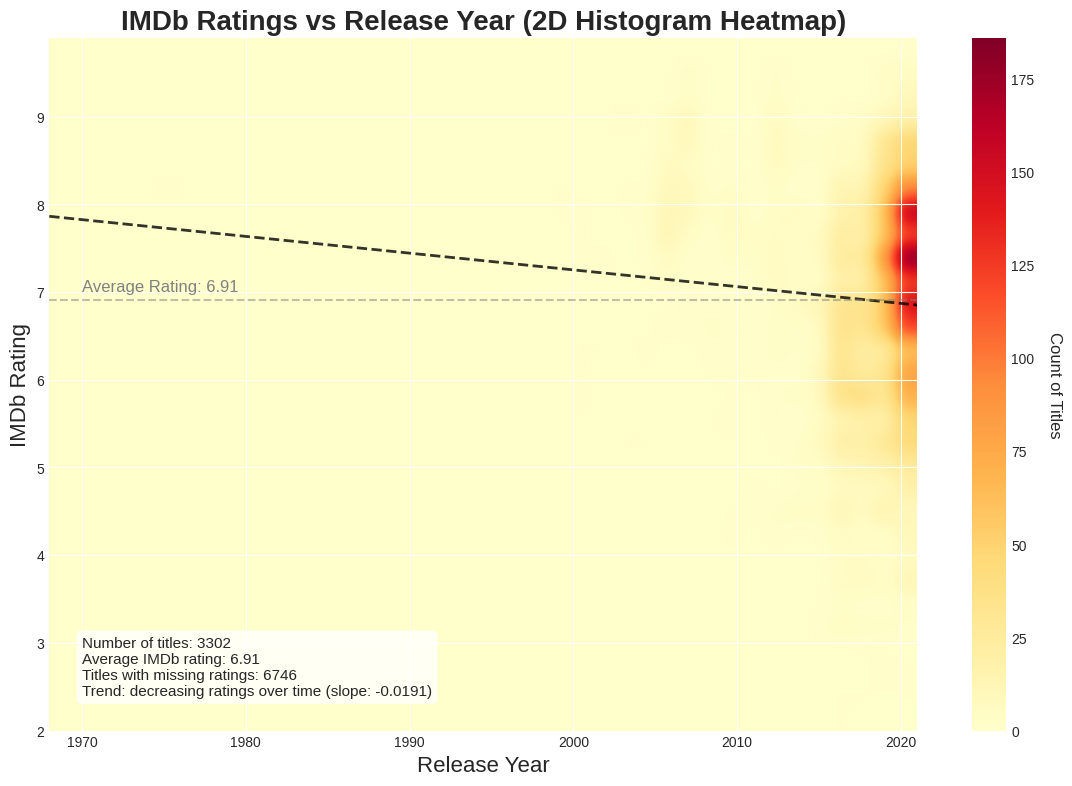

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from google.colab import drive

# Mount Google Drive (if using Colab)
drive.mount('/content/drive')

# Set the aesthetic style of the plots
plt.style.use('seaborn-v0_8-darkgrid')

# Load your data from the specific path
file_path = "/content/drive/My Drive/DATA 230/Sem Project/Trial 01"
df = pd.read_csv(file_path + '/netflix_show_with_scores.csv')

# Convert 'scores' column to numeric values, errors will be converted to NaN
df['scores'] = pd.to_numeric(df['scores'], errors='coerce')

# Clean data by dropping NaN values in scores
df_clean = df.dropna(subset=['scores'])

# Create a figure with appropriate size
plt.figure(figsize=(14, 9))

# Create a 2D histogram using hexbin
# This will show density of points as a heatmap
hexbin = plt.hexbin(
    df_clean['release_year'],
    df_clean['scores'],
    gridsize=30,  # Adjust this value to control resolution
    cmap='YlOrRd',  # Yellow-Orange-Red colormap
    alpha=0.8,
    linewidths=0.2,
    mincnt=1  # Minimum count to color a hexagon
)

# Add a trend line to show the overall pattern
x = df_clean['release_year'].values
y = df_clean['scores'].values
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
x_range = np.linspace(min(x), max(x), 100)
plt.plot(x_range, p(x_range), 'k--', alpha=0.8, linewidth=2)

# Calculate slope and intercept for annotation
slope, intercept = z
trend_direction = "decreasing" if slope < 0 else "increasing"

# Add title and labels
plt.title('IMDb Ratings vs Release Year (Density Heatmap)', fontsize=20, fontweight='bold')
plt.xlabel('Release Year', fontsize=16)
plt.ylabel('IMDb Rating', fontsize=16)

# Set y-axis limits to better display the ratings range
plt.ylim(min(y) - 0.3, max(y) + 0.3)

# Add a horizontal line for the average rating
avg_rating = y.mean()
plt.axhline(y=avg_rating, color='gray', linestyle='--', alpha=0.5)
plt.text(
    min(x) + 2,
    avg_rating + 0.1,
    f'Average Rating: {avg_rating:.2f}',
    fontsize=12,
    color='gray'
)

# Add a colorbar to show the density scale
cbar = plt.colorbar(hexbin, pad=0.01)
cbar.set_label('Count of Titles', rotation=270, labelpad=20, fontsize=12)

# Remove unnecessary spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Add a brief summary of the visualization
stats_text = (
    f"Number of titles: {len(df_clean)}\n"
    f"Average IMDb rating: {avg_rating:.2f}\n"
    f"Titles with missing ratings: {len(df) - len(df_clean)}\n"
    f"Trend: {trend_direction} ratings over time (slope: {slope:.4f})"
)
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.text(
    min(x) + 2,
    min(y) + 0.4,
    stats_text,
    fontsize=11,
    bbox=props
)

# Adjust tick sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig('imdb_ratings_by_year_heatmap.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

# Print additional insights
print(f"Correlation between release year and IMDb rating: {np.corrcoef(x, y)[0,1]:.3f}")
print(f"Titles by decade:")
df_clean['decade'] = (df_clean['release_year'] // 10) * 10
decade_counts = df_clean['decade'].value_counts().sort_index()
for decade, count in decade_counts.items():
    print(f"{decade}s: {count} titles")

# Alternative: Create a traditional heatmap using 2D histogram
plt.figure(figsize=(14, 9))

# Create 2D histogram data
heatmap, xedges, yedges = np.histogram2d(
    df_clean['release_year'],
    df_clean['scores'],
    bins=[40, 30]  # Adjust these values for resolution
)

# Get extent of the heatmap
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# Plot the heatmap
plt.imshow(
    heatmap.T,  # Transpose to get correct orientation
    extent=extent,
    origin='lower',
    aspect='auto',
    cmap='YlOrRd',
    interpolation='gaussian'  # Smooth the heatmap appearance
)

# Add the trend line
plt.plot(x_range, p(x_range), 'k--', alpha=0.8, linewidth=2)

# Add labels and title
plt.title('IMDb Ratings vs Release Year (2D Histogram Heatmap)', fontsize=20, fontweight='bold')
plt.xlabel('Release Year', fontsize=16)
plt.ylabel('IMDb Rating', fontsize=16)

# Add the average line
plt.axhline(y=avg_rating, color='gray', linestyle='--', alpha=0.5)
plt.text(
    min(x) + 2,
    avg_rating + 0.1,
    f'Average Rating: {avg_rating:.2f}',
    fontsize=12,
    color='gray'
)

# Add colorbar
cbar = plt.colorbar()
cbar.set_label('Count of Titles', rotation=270, labelpad=20, fontsize=12)

# Add the stats text box
plt.text(
    min(x) + 2,
    min(y) + 0.4,
    stats_text,
    fontsize=11,
    bbox=props
)

# Save this alternative figure
plt.savefig('imdb_ratings_by_year_2d_histogram.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

## Combine IMDb data (enriched data + imdb vote and rating)

In [ ]:
import requests
import time
import pandas as pd

OMDB_API_KEY = "47d2b5c5"
df = pd.read_csv("Netflix_Titles__US__After_2000__Enriched_.csv")

df["imdbRating"] = None
df["imdbVotes"] = None

def get_imdb_info(title, year):
    url = f"http://www.omdbapi.com/?t={title}&y={year}&apikey={OMDB_API_KEY}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        if data.get("Response") == "True":
            return data.get("imdbRating"), data.get("imdbVotes")
    return None, None

for idx, row in df.iterrows():
    title = row["title"]
    year = row["release_year"]
    print(f"Querying: {title} ({year})")

    try:
        rating, votes = get_imdb_info(title, year)
        df.at[idx, "imdbRating"] = rating
        df.at[idx, "imdbVotes"] = votes
    except Exception as e:
        print(f"Error: Failed to fetch data for {title}, reason: {e}")
    
    time.sleep(1) 

df.to_csv("Netflix_imdb_final.csv", index=False)

## Clean and preprocess combined data (data + imdb vote and rating)

In [15]:
import pandas as pd
df = pd.read_csv("netflix_imdb_final.csv")
summary = pd.DataFrame({
    'Data Type': df.dtypes,
    'Missing Values': df.isnull().sum()
})
print(summary)

                                Data Type  Missing Values
Unnamed: 0                          int64               0
show_id                            object               0
type                               object               0
title                              object               0
director                           object             748
cast                               object             316
country                            object               0
date_added                         object               6
release_year                        int64               0
rating                             object               0
duration                           object               3
listed_in                          object               0
description                        object               0
budget                              int64               0
production_company_track_record     int64               0
director_success                    int64               0
cast_popularit

In [16]:
import pandas as pd

def clean_netflix_dataframe(df):
    # Standardize column names
    df.columns = df.columns.str.lower().str.replace(' ', '_')

    # Normalize text columns: lowercase and strip spaces
    text_cols = ['show_id', 'type', 'title', 'director', 'cast', 
                 'country', 'rating', 'duration', 'listed_in', 'genre_trend', 'release_season']
    for col in text_cols:
        if col in df.columns:
            df[col] = df[col].astype(str).str.strip().str.lower()

    # Convert 'date_added' to datetime and drop rows with missing 'date_added'
    if 'date_added' in df.columns:
        df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')
        df = df[~df['date_added'].isna()]  # Remove rows where 'date_added' is NaN

    # Extract 'duration_minutes' and 'duration_seasons'
    if 'duration' in df.columns:
        df['duration_minutes'] = df['duration'].str.extract(r'(\d+)\s*min', expand=False).astype(float)
        df['duration_seasons'] = df['duration'].str.extract(r'(\d+)\s*season', expand=False).astype(float)

        # Fill missing values with the most frequent value (mode)
        df['duration_minutes'] = df['duration_minutes'].fillna(df['duration_minutes'].mode()[0])
        df['duration_seasons'] = df['duration_seasons'].fillna(df['duration_seasons'].mode()[0])

        # Drop the original 'duration' column
        df.drop(columns=['duration'], inplace=True)

    # Drop unnecessary columns
    for col in ['country']:
        if col in df.columns:
            df.drop(columns=[col], inplace=True)

    # Convert 'imdbRating' to numeric
    if 'imdbrating' in df.columns:
        df['imdbrating'] = pd.to_numeric(df['imdbrating'], errors='coerce')

    # Convert 'imdbVotes' to numeric after removing commas
    if 'imdbvotes' in df.columns:
        df['imdbvotes'] = df['imdbvotes'].str.replace(',', '', regex=False)
        df['imdbvotes'] = pd.to_numeric(df['imdbvotes'], errors='coerce')

    # Drop rows where 'imdbrating' or 'imdbvotes' are missing
    df.dropna(subset=['imdbrating', 'imdbvotes'], inplace=True)

    # Drop rows with any missing values
    df.dropna(inplace=True)

    # Drop duplicate rows
    df.drop_duplicates(inplace=True)

    return df


In [17]:
df = clean_netflix_dataframe(df)

df.head()

C:\Users\jiehe\AppData\Local\Temp\ipykernel_20276\2539816628.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['duration_minutes'] = df['duration'].str.extract(r'(\d+)\s*min', expand=False).astype(float)
C:\Users\jiehe\AppData\Local\Temp\ipykernel_20276\2539816628.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['duration_seasons'] = df['duration'].str.extract(r'(\d+)\s*season', expand=False).astype(float)
C:\Users\jiehe\AppData\Local\Temp\ipykernel_20276\2539816628.py:25: SettingWithCopyWarnin

unnamed:_0 show_id     type                                   title  \
0           0      s1    movie                    dick johnson is dead   
1           9     s10    movie                            the starling   
3          27     s28    movie                               grown ups   
4          28     s29    movie                              dark skies   
5          40     s41  tv show  he-man and the masters of the universe   

          director                                               cast  \
0  kirsten johnson                                                nan   
1   theodore melfi  melissa mccarthy, chris o'dowd, kevin kline, t...   
3     dennis dugan  adam sandler, kevin james, chris rock, david s...   
4    scott stewart  keri russell, josh hamilton, j.k. simmons, dak...   
5              nan  yuri lowenthal, kimberly brooks, antony del ri...   

  date_added  release_year rating                        listed_in  ...  \
0 2021-09-25          2020  pg-13                    documentaries  ...   
1 2021-09-24          2021  pg-13                 comedies, dramas  ...   
3 2021-09-20          2010  pg-13                         comedies  ...   
4 2021-09-19          2013  pg-13  horror movies, sci-fi & fantasy  ...   
5 2021-09-16          2021  tv-y7    kids' tv, tv sci-fi & fantasy  ...   

  production_company_track_record  director_success  cast_popularity  \
0                              88                57               24   
1                              74                95               94   
3                              40                90              100   
4                              71                97              100   
5                              57                46               94   

   genre_trend  release_season marketing_budget imdbrating  imdbvotes  \
0     trending            fall         34384167        7.4     7364.0   
1     trending            fall         17017741        6.4    15804.0   
3     trending            fall          8543054        6.0   293554.0   
4       stable            fall          9421973        6.3    81301.0   
5    declining            fall            69861        5.9     2324.0   

   duration_minutes  duration_seasons  
0              90.0               1.0  
1             104.0               1.0  
3             103.0               1.0  
4              97.0               1.0  
5              90.0               1.0  

[5 rows x 22 columns]

In [18]:
summary = pd.DataFrame({
    'Data Type': df.dtypes,
    'Missing Values': df.isnull().sum()
})
print(summary)

                                      Data Type  Missing Values
unnamed:_0                                int64               0
show_id                                  object               0
type                                     object               0
title                                    object               0
director                                 object               0
cast                                     object               0
date_added                       datetime64[ns]               0
release_year                              int64               0
rating                                   object               0
listed_in                                object               0
description                              object               0
budget                                    int64               0
production_company_track_record           int64               0
director_success                          int64               0
cast_popularity                         

## NLP

In [19]:
"""
This code processes the 'cast' column in a dataset to clean and extract relevant information for easier analysis.
The steps and their purposes are as follows:

1. **Clean and Format the 'cast' Column**:
   - Ensure that the 'cast' column is a string.
   - Remove extra spaces around names.
   - Capitalize the first letter of each word in the names (e.g., 'john doe' → 'John Doe').
   - This step standardizes the formatting of names, making them consistent and easier to read.

2. **Convert 'cast' into a List**:
   - Split the string in the 'cast' column into a list of individual names, separating them by commas.
   - This makes it easier to manipulate and access individual cast members for further processing.

3. **Extract the Main Cast**:
   - Create a new column, 'main_cast', by extracting the first 1-5 actors from the cast list.
   - This step focuses on the primary actors, which are typically more relevant for analysis or display purposes.
   - If the cast information is missing or not in the expected format, assign 'Unknown' as the default value.

4. **Remove the Intermediate 'cast_list' Column**:
   - Drop the 'cast_list' column after processing to keep the dataset clean and retain only the essential columns: the cleaned 'cast' and 'main_cast'.
   - This ensures the dataset is concise and avoids unnecessary intermediate data.

5. **Display the Processed Data**:
   - Use `df.head()` to preview the cleaned and processed dataset, including the original 'cast' and the newly added 'main_cast' column.
"""

# Ensure 'cast' is a string, remove extra spaces, and capitalize the first letter of each word
df['cast'] = df['cast'].apply(lambda x: ', '.join([name.strip().title() for name in x.split(',')]) if isinstance(x, str) else x)

# Convert 'cast' column into a list format for easier manipulation
df['cast_list'] = df['cast'].str.split(', ')

# Create a new column 'main_cast' by extracting the first 1-5 actors from the 'cast_list'
df['main_cast'] = df['cast_list'].apply(lambda x: ', '.join(x[:5]) if isinstance(x, list) else 'Unknown')

# Optionally remove the intermediate 'cast_list' column, keeping the cleaned 'cast' and 'main_cast' columns
df.drop(columns=['cast_list'], inplace=True)

# Display the results with the original 'cast' and the newly added 'main_cast'
df.head()

unnamed:_0 show_id     type                                   title  \
0           0      s1    movie                    dick johnson is dead   
1           9     s10    movie                            the starling   
3          27     s28    movie                               grown ups   
4          28     s29    movie                              dark skies   
5          40     s41  tv show  he-man and the masters of the universe   

          director                                               cast  \
0  kirsten johnson                                                Nan   
1   theodore melfi  Melissa Mccarthy, Chris O'Dowd, Kevin Kline, T...   
3     dennis dugan  Adam Sandler, Kevin James, Chris Rock, David S...   
4    scott stewart  Keri Russell, Josh Hamilton, J.K. Simmons, Dak...   
5              nan  Yuri Lowenthal, Kimberly Brooks, Antony Del Ri...   

  date_added  release_year rating                        listed_in  ...  \
0 2021-09-25          2020  pg-13                    documentaries  ...   
1 2021-09-24          2021  pg-13                 comedies, dramas  ...   
3 2021-09-20          2010  pg-13                         comedies  ...   
4 2021-09-19          2013  pg-13  horror movies, sci-fi & fantasy  ...   
5 2021-09-16          2021  tv-y7    kids' tv, tv sci-fi & fantasy  ...   

  director_success  cast_popularity  genre_trend  release_season  \
0               57               24     trending            fall   
1               95               94     trending            fall   
3               90              100     trending            fall   
4               97              100       stable            fall   
5               46               94    declining            fall   

   marketing_budget imdbrating imdbvotes  duration_minutes  duration_seasons  \
0          34384167        7.4    7364.0              90.0               1.0   
1          17017741        6.4   15804.0             104.0               1.0   
3           8543054        6.0  293554.0             103.0               1.0   
4           9421973        6.3   81301.0              97.0               1.0   
5             69861        5.9    2324.0              90.0               1.0   

                                           main_cast  
0                                                Nan  
1  Melissa Mccarthy, Chris O'Dowd, Kevin Kline, T...  
3  Adam Sandler, Kevin James, Chris Rock, David S...  
4  Keri Russell, Josh Hamilton, J.K. Simmons, Dak...  
5  Yuri Lowenthal, Kimberly Brooks, Antony Del Ri...  

[5 rows x 23 columns]

In [20]:
pip install nltk

In [21]:
"""
This code processes and cleans the 'description' column from a dataset to prepare it for further analysis. 
Here's an overview of the operations performed and the rationale behind each:

1. **Handle Missing Values**:
   - Replace any null values in the 'description' column with empty strings to ensure uniform data structure.
   - This prevents errors in subsequent steps and ensures all descriptions are properly processed.

2. **Tokenization**:
   - Use the `split()` method to break the text into individual words.
   - This is a simple and efficient way to tokenize descriptions into smaller units for analysis.

3. **Remove Stopwords**:
   - Remove common words (e.g., 'and', 'the', 'is') that do not carry significant meaning.
   - This step helps retain only the most important words, reducing noise in the data.

4. **Stemming**:
   - Convert words to their root forms using Porter Stemmer (e.g., 'running' → 'run').
"""

from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import nltk

# Ensure 'description' column is a string
df['description'] = df['description'].fillna('').astype(str)

# Tokenize the description column using split()
df['description_tokens'] = df['description'].apply(lambda x: x.split())

# Remove common stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
df['description_tokens'] = df['description_tokens'].apply(
    lambda x: [word for word in x if word.lower() not in stop_words]
)

# Apply stemming to reduce words to their root form
stemmer = PorterStemmer()
df['description_tokens'] = df['description_tokens'].apply(
    lambda x: [stemmer.stem(word) for word in x]
)

# Display results
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jiehe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


unnamed:_0 show_id     type                                   title  \
0           0      s1    movie                    dick johnson is dead   
1           9     s10    movie                            the starling   
3          27     s28    movie                               grown ups   
4          28     s29    movie                              dark skies   
5          40     s41  tv show  he-man and the masters of the universe   

          director                                               cast  \
0  kirsten johnson                                                Nan   
1   theodore melfi  Melissa Mccarthy, Chris O'Dowd, Kevin Kline, T...   
3     dennis dugan  Adam Sandler, Kevin James, Chris Rock, David S...   
4    scott stewart  Keri Russell, Josh Hamilton, J.K. Simmons, Dak...   
5              nan  Yuri Lowenthal, Kimberly Brooks, Antony Del Ri...   

  date_added  release_year rating                        listed_in  ...  \
0 2021-09-25          2020  pg-13                    documentaries  ...   
1 2021-09-24          2021  pg-13                 comedies, dramas  ...   
3 2021-09-20          2010  pg-13                         comedies  ...   
4 2021-09-19          2013  pg-13  horror movies, sci-fi & fantasy  ...   
5 2021-09-16          2021  tv-y7    kids' tv, tv sci-fi & fantasy  ...   

  cast_popularity  genre_trend  release_season  marketing_budget  imdbrating  \
0              24     trending            fall          34384167         7.4   
1              94     trending            fall          17017741         6.4   
3             100     trending            fall           8543054         6.0   
4             100       stable            fall           9421973         6.3   
5              94    declining            fall             69861         5.9   

  imdbvotes duration_minutes  duration_seasons  \
0    7364.0             90.0               1.0   
1   15804.0            104.0               1.0   
3  293554.0            103.0               1.0   
4   81301.0             97.0               1.0   
5    2324.0             90.0               1.0   

                                           main_cast  \
0                                                Nan   
1  Melissa Mccarthy, Chris O'Dowd, Kevin Kline, T...   
3  Adam Sandler, Kevin James, Chris Rock, David S...   
4  Keri Russell, Josh Hamilton, J.K. Simmons, Dak...   
5  Yuri Lowenthal, Kimberly Brooks, Antony Del Ri...   

                                  description_tokens  
0  [father, near, end, life,, filmmak, kirsten, j...  
1  [woman, adjust, life, loss, contend, feisti, b...  
3  [mourn, loss, belov, junior, high, basketbal, ...  
4  [family’, idyl, suburban, life, shatter, alien...  
5  [mighti, teen, adam, heroic, squad, misfit, di...  

[5 rows x 24 columns]

In [22]:
"""
Use TF-IDF Vectorizer to extrac 5-10 key words from description and add a new column called keywords.
"""
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF Vectorizer with a higher feature limit
tfidf = TfidfVectorizer(max_features=100, stop_words='english')  # More features for flexibility
tfidf_matrix = tfidf.fit_transform(df['description'].dropna())  # Transform non-null descriptions
feature_names = tfidf.get_feature_names_out()

# Function to extract at least 5 and at most 10 keywords
def extract_keywords(row):
    if pd.isna(row):  # Return empty list if the row is NaN
        return []
    tfidf_scores = tfidf.transform([row]).toarray().flatten()  # Get TF-IDF scores
    sorted_indices = tfidf_scores.argsort()[::-1]  # Indices sorted in descending order of scores
    # Select the top-scoring keywords
    keywords = [feature_names[i] for i in sorted_indices if tfidf_scores[i] > 0][:10]
    # Ensure there are at least 5 keywords by adding low-scoring ones if necessary
    if len(keywords) < 5:
        keywords = [feature_names[i] for i in sorted_indices[:5]]
    return keywords

# Apply the extraction function to the 'description' column
df['keywords'] = df['description'].apply(extract_keywords)
df.head()

unnamed:_0 show_id     type                                   title  \
0           0      s1    movie                    dick johnson is dead   
1           9     s10    movie                            the starling   
3          27     s28    movie                               grown ups   
4          28     s29    movie                              dark skies   
5          40     s41  tv show  he-man and the masters of the universe   

          director                                               cast  \
0  kirsten johnson                                                Nan   
1   theodore melfi  Melissa Mccarthy, Chris O'Dowd, Kevin Kline, T...   
3     dennis dugan  Adam Sandler, Kevin James, Chris Rock, David S...   
4    scott stewart  Keri Russell, Josh Hamilton, J.K. Simmons, Dak...   
5              nan  Yuri Lowenthal, Kimberly Brooks, Antony Del Ri...   

  date_added  release_year rating                        listed_in  ...  \
0 2021-09-25          2020  pg-13                    documentaries  ...   
1 2021-09-24          2021  pg-13                 comedies, dramas  ...   
3 2021-09-20          2010  pg-13                         comedies  ...   
4 2021-09-19          2013  pg-13  horror movies, sci-fi & fantasy  ...   
5 2021-09-16          2021  tv-y7    kids' tv, tv sci-fi & fantasy  ...   

  genre_trend  release_season  marketing_budget  imdbrating  imdbvotes  \
0    trending            fall          34384167         7.4     7364.0   
1    trending            fall          17017741         6.4    15804.0   
3    trending            fall           8543054         6.0   293554.0   
4      stable            fall           9421973         6.3    81301.0   
5   declining            fall             69861         5.9     2324.0   

  duration_minutes duration_seasons  \
0             90.0              1.0   
1            104.0              1.0   
3            103.0              1.0   
4             97.0              1.0   
5             90.0              1.0   

                                           main_cast  \
0                                                Nan   
1  Melissa Mccarthy, Chris O'Dowd, Kevin Kline, T...   
3  Adam Sandler, Kevin James, Chris Rock, David S...   
4  Keri Russell, Josh Hamilton, J.K. Simmons, Dak...   
5  Yuri Lowenthal, Kimberly Brooks, Antony Del Ri...   

                                  description_tokens  \
0  [father, near, end, life,, filmmak, kirsten, j...   
1  [woman, adjust, life, loss, contend, feisti, b...   
3  [mourn, loss, belov, junior, high, basketbal, ...   
4  [family’, idyl, suburban, life, shatter, alien...   
5  [mighti, teen, adam, heroic, squad, misfit, di...   

                                keywords  
0     [death, father, help, life, young]  
1  [struggling, way, woman, life, young]  
3       [house, high, help, film, finds]  
4      [home, family, life, group, film]  
5      [teen, young, group, film, finds]  

[5 rows x 25 columns]

## Encode the category data

In [23]:
from sklearn.preprocessing import LabelEncoder
label_encoders = {}

columns_to_encode = ['type','rating','release_season']
for col in columns_to_encode:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

df.head()

unnamed:_0 show_id  type                                   title  \
0           0      s1     0                    dick johnson is dead   
1           9     s10     0                            the starling   
3          27     s28     0                               grown ups   
4          28     s29     0                              dark skies   
5          40     s41     1  he-man and the masters of the universe   

          director                                               cast  \
0  kirsten johnson                                                Nan   
1   theodore melfi  Melissa Mccarthy, Chris O'Dowd, Kevin Kline, T...   
3     dennis dugan  Adam Sandler, Kevin James, Chris Rock, David S...   
4    scott stewart  Keri Russell, Josh Hamilton, J.K. Simmons, Dak...   
5              nan  Yuri Lowenthal, Kimberly Brooks, Antony Del Ri...   

  date_added  release_year  rating                        listed_in  ...  \
0 2021-09-25          2020       6                    documentaries  ...   
1 2021-09-24          2021       6                 comedies, dramas  ...   
3 2021-09-20          2010       6                         comedies  ...   
4 2021-09-19          2013       6  horror movies, sci-fi & fantasy  ...   
5 2021-09-16          2021      13    kids' tv, tv sci-fi & fantasy  ...   

  genre_trend  release_season  marketing_budget  imdbrating  imdbvotes  \
0    trending               0          34384167         7.4     7364.0   
1    trending               0          17017741         6.4    15804.0   
3    trending               0           8543054         6.0   293554.0   
4      stable               0           9421973         6.3    81301.0   
5   declining               0             69861         5.9     2324.0   

  duration_minutes  duration_seasons  \
0             90.0               1.0   
1            104.0               1.0   
3            103.0               1.0   
4             97.0               1.0   
5             90.0               1.0   

                                           main_cast  \
0                                                Nan   
1  Melissa Mccarthy, Chris O'Dowd, Kevin Kline, T...   
3  Adam Sandler, Kevin James, Chris Rock, David S...   
4  Keri Russell, Josh Hamilton, J.K. Simmons, Dak...   
5  Yuri Lowenthal, Kimberly Brooks, Antony Del Ri...   

                                  description_tokens  \
0  [father, near, end, life,, filmmak, kirsten, j...   
1  [woman, adjust, life, loss, contend, feisti, b...   
3  [mourn, loss, belov, junior, high, basketbal, ...   
4  [family’, idyl, suburban, life, shatter, alien...   
5  [mighti, teen, adam, heroic, squad, misfit, di...   

                                keywords  
0     [death, father, help, life, young]  
1  [struggling, way, woman, life, young]  
3       [house, high, help, film, finds]  
4      [home, family, life, group, film]  
5      [teen, young, group, film, finds]  

[5 rows x 25 columns]

## Standardlize the budget data

In [24]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Standardize the 'marketing_budget' column
df['marketing_budget'] = scaler.fit_transform(df[['marketing_budget']])

# Check the results
df.head()

unnamed:_0 show_id  type                                   title  \
0           0      s1     0                    dick johnson is dead   
1           9     s10     0                            the starling   
3          27     s28     0                               grown ups   
4          28     s29     0                              dark skies   
5          40     s41     1  he-man and the masters of the universe   

          director                                               cast  \
0  kirsten johnson                                                Nan   
1   theodore melfi  Melissa Mccarthy, Chris O'Dowd, Kevin Kline, T...   
3     dennis dugan  Adam Sandler, Kevin James, Chris Rock, David S...   
4    scott stewart  Keri Russell, Josh Hamilton, J.K. Simmons, Dak...   
5              nan  Yuri Lowenthal, Kimberly Brooks, Antony Del Ri...   

  date_added  release_year  rating                        listed_in  ...  \
0 2021-09-25          2020       6                    documentaries  ...   
1 2021-09-24          2021       6                 comedies, dramas  ...   
3 2021-09-20          2010       6                         comedies  ...   
4 2021-09-19          2013       6  horror movies, sci-fi & fantasy  ...   
5 2021-09-16          2021      13    kids' tv, tv sci-fi & fantasy  ...   

  genre_trend  release_season  marketing_budget  imdbrating  imdbvotes  \
0    trending               0          2.337185         7.4     7364.0   
1    trending               0          0.592813         6.4    15804.0   
3    trending               0         -0.258428         6.0   293554.0   
4      stable               0         -0.170145         6.3    81301.0   
5   declining               0         -1.109519         5.9     2324.0   

  duration_minutes  duration_seasons  \
0             90.0               1.0   
1            104.0               1.0   
3            103.0               1.0   
4             97.0               1.0   
5             90.0               1.0   

                                           main_cast  \
0                                                Nan   
1  Melissa Mccarthy, Chris O'Dowd, Kevin Kline, T...   
3  Adam Sandler, Kevin James, Chris Rock, David S...   
4  Keri Russell, Josh Hamilton, J.K. Simmons, Dak...   
5  Yuri Lowenthal, Kimberly Brooks, Antony Del Ri...   

                                  description_tokens  \
0  [father, near, end, life,, filmmak, kirsten, j...   
1  [woman, adjust, life, loss, contend, feisti, b...   
3  [mourn, loss, belov, junior, high, basketbal, ...   
4  [family’, idyl, suburban, life, shatter, alien...   
5  [mighti, teen, adam, heroic, squad, misfit, di...   

                                keywords  
0     [death, father, help, life, young]  
1  [struggling, way, woman, life, young]  
3       [house, high, help, film, finds]  
4      [home, family, life, group, film]  
5      [teen, young, group, film, finds]  

[5 rows x 25 columns]

## Parameter Selection: Analysis on Imdb rating and vote data distribution and add popularity as target

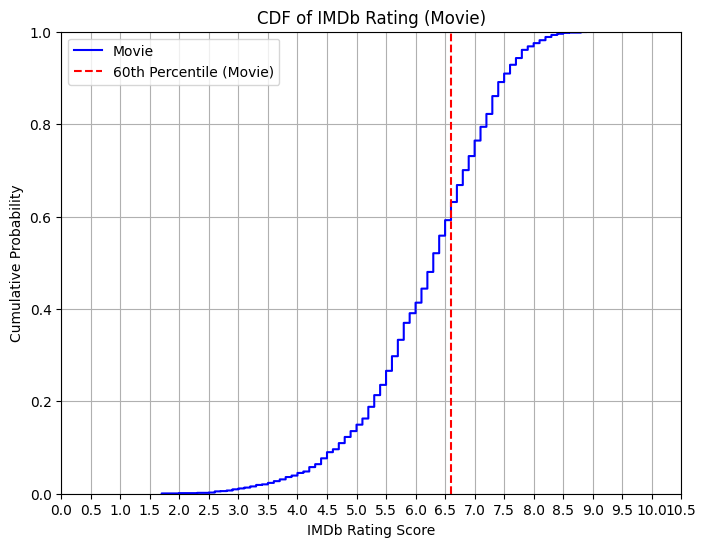

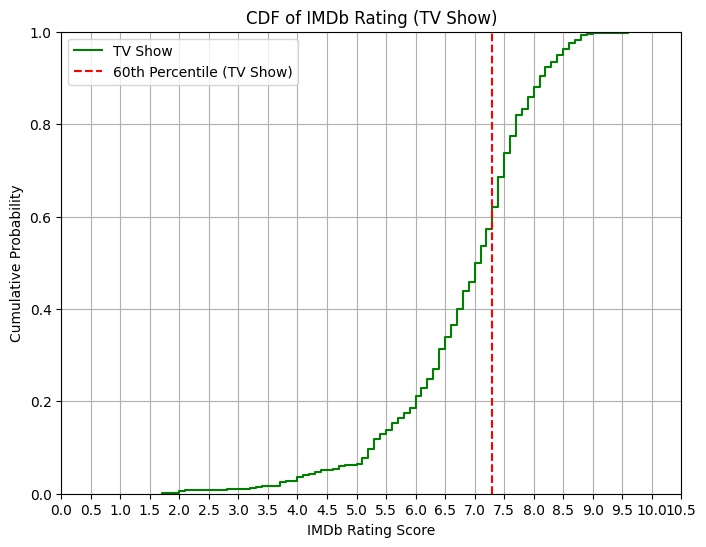

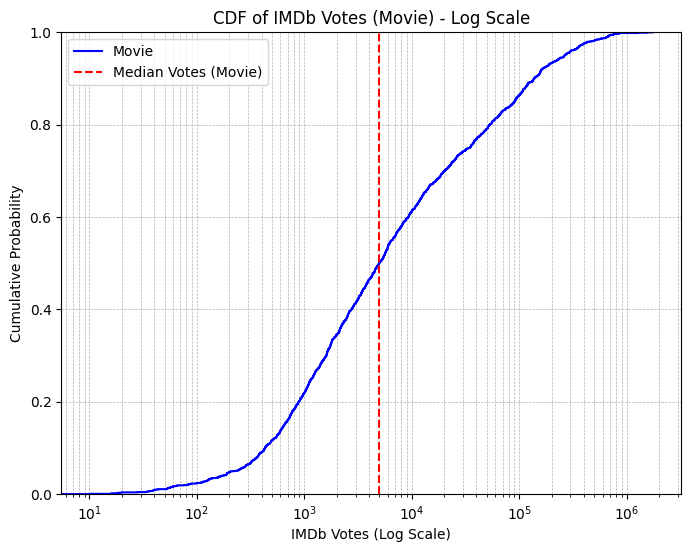

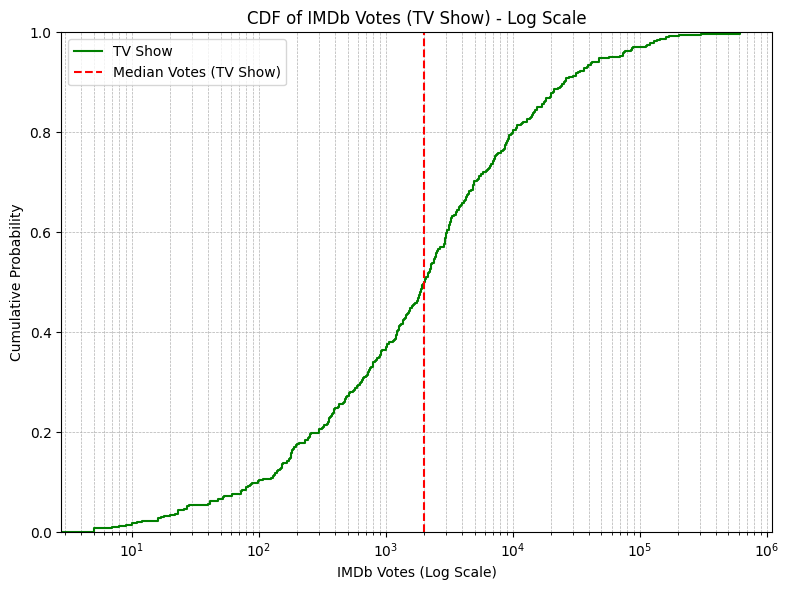

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# IMDb Rating CDF for type 0 (Movie)
plt.figure(figsize=(8, 6))
sns.ecdfplot(df[df['type'] == 0]['imdbrating'], label='Movie', color='b')
plt.axvline(df[df['type'] == 0]['imdbrating'].quantile(0.6), color='r', linestyle='--', label='60th Percentile (Movie)')
plt.title("CDF of IMDb Rating (Movie)")
plt.xlabel("IMDb Rating Score")
plt.ylabel("Cumulative Probability")
plt.xticks(np.arange(0, 11, 0.5))
plt.grid(True)
plt.legend()

# IMDb Rating CDF for type 1 (TV Show)
plt.figure(figsize=(8, 6))
sns.ecdfplot(df[df['type'] == 1]['imdbrating'], label='TV Show', color='g')
plt.axvline(df[df['type'] == 1]['imdbrating'].quantile(0.6), color='r', linestyle='--', label='60th Percentile (TV Show)')
plt.title("CDF of IMDb Rating (TV Show)")
plt.xlabel("IMDb Rating Score")
plt.ylabel("Cumulative Probability")
plt.xticks(np.arange(0, 11, 0.5))
plt.grid(True)
plt.legend()

# IMDb Votes CDF (Log Scale) for type 0 (Movie)
plt.figure(figsize=(8, 6))
sns.ecdfplot(df[df['type'] == 0]['imdbvotes'], label='Movie', color='b')
plt.axvline(df[df['type'] == 0]['imdbvotes'].quantile(0.5), color='r', linestyle='--', label='Median Votes (Movie)')
plt.xscale('log')
plt.title("CDF of IMDb Votes (Movie) - Log Scale")
plt.xlabel("IMDb Votes (Log Scale)")
plt.ylabel("Cumulative Probability")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

# IMDb Votes CDF (Log Scale) for type 1 (TV Show)
plt.figure(figsize=(8, 6))
sns.ecdfplot(df[df['type'] == 1]['imdbvotes'], label='TV Show', color='g')
plt.axvline(df[df['type'] == 1]['imdbvotes'].quantile(0.5), color='r', linestyle='--', label='Median Votes (TV Show)')
plt.xscale('log')
plt.title("CDF of IMDb Votes (TV Show) - Log Scale")
plt.xlabel("IMDb Votes (Log Scale)")
plt.ylabel("Cumulative Probability")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

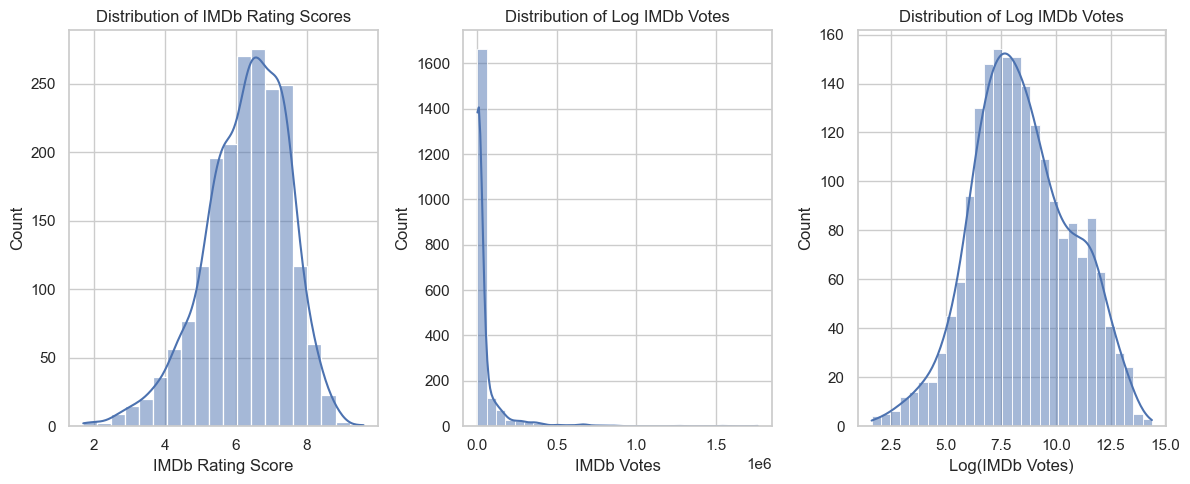

In [54]:
plt.figure(figsize=(12, 5))

# Rating
plt.subplot(1, 3, 1)
sns.histplot(df['imdbrating'], bins=20, kde=True)
plt.title("Distribution of IMDb Rating Scores")
plt.xlabel("IMDb Rating Score")
plt.ylabel("Count")
plt.grid(True)

# Votes
plt.subplot(1, 3, 2)
sns.histplot(df['imdbvotes'], bins=30, kde=True)
plt.title("Distribution of Log IMDb Votes")
plt.xlabel("IMDb Votes")
plt.ylabel("Count")
plt.grid(True)

# Votes (Log)
plt.subplot(1, 3, 3)
sns.histplot(np.log(df['imdbvotes']), bins=30, kde=True)
plt.title("Distribution of Log IMDb Votes")
plt.xlabel("Log(IMDb Votes)")
plt.ylabel("Count")
plt.grid(True)

plt.tight_layout()
plt.show()

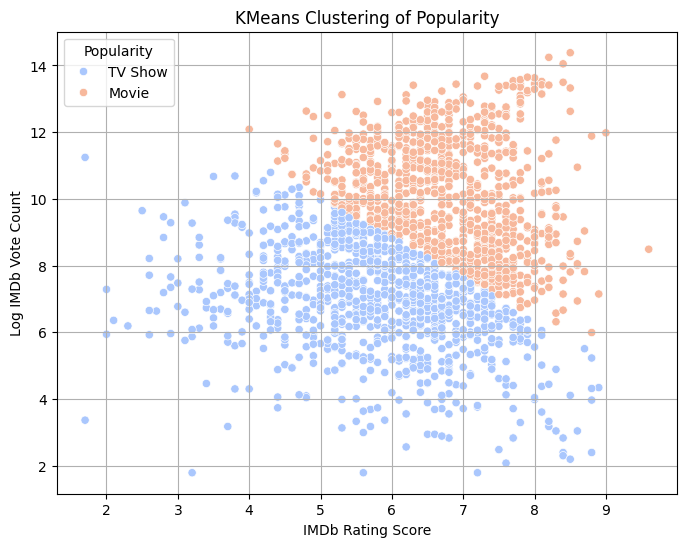

In [28]:
from sklearn.cluster import KMeans
# Feature scaling (Note: votes have been log-transformed)
features = df[['imdbrating', 'votes_log']]
scaled = StandardScaler().fit_transform(features)

# Clustering using KMeans
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
df['popularity_cluster'] = kmeans.fit_predict(scaled)

# Identify which cluster is the popular one (higher average rating)
cluster_avg = df.groupby('popularity_cluster')['imdbrating'].mean()
popular_cluster = cluster_avg.idxmax()

# Mark the popular cluster
df['popularity_kmeans'] = (df['popularity_cluster'] == popular_cluster).astype(int)

# Visualization: Scatter plot of the clustering results
plt.figure(figsize=(8, 6))
scatter = sns.scatterplot(data=df, x='imdbrating', y='votes_log', hue='popularity_kmeans', palette='coolwarm')

# Customize legend labels
handles, labels = scatter.get_legend_handles_labels()
plt.legend(handles, ["TV Show", "Movie"], title="Popularity")

plt.title("KMeans Clustering of Popularity")
plt.xlabel("IMDb Rating Score")
plt.ylabel("Log IMDb Vote Count")
plt.grid()
plt.show()

In [29]:
df.to_csv("netflix_imdb_without_popularity.csv", index=False)
print("✅ Query completed. Results saved as 'netflix_imdb_without_popularity.csv'")

✅ Query completed. Results saved as 'netflix_imdb_without_popularity.csv'


## Z-score Combined Method

In [44]:
import pandas as pd
df = pd.read_csv("netflix_imdb_without_popularity.csv")

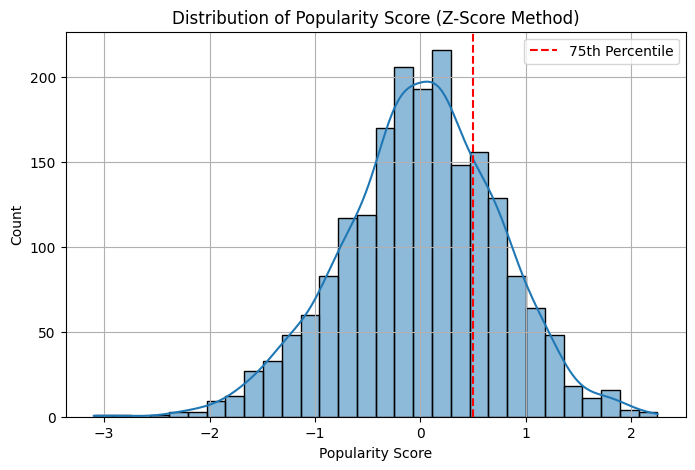

In [45]:
from scipy.stats import zscore

# Calculate Z-score (ratings are not log-transformed, votes are log-transformed)
df['votes_log'] = np.log1p(df['imdbvotes'])  # Avoid log(0)
df['rating_z'] = zscore(df['imdbrating'])
df['votes_z'] = zscore(df['votes_log'])

# Composite score (weights can be adjusted, here both are 0.5)
df['popularity_score'] = 0.5 * df['rating_z'] + 0.5 * df['votes_z']

# Use the 75th percentile as the threshold for popular items
score_threshold = df['popularity_score'].quantile(0.75)
df['popularity_zscore'] = (df['popularity_score'] >= score_threshold).astype(int)

# Visualization: Distribution of popularity scores
plt.figure(figsize=(8, 5))
sns.histplot(df['popularity_score'], bins=30, kde=True)
plt.axvline(score_threshold, color='r', linestyle='--', label='75th Percentile')
plt.title("Distribution of Popularity Score (Z-Score Method)")
plt.xlabel("Popularity Score")
plt.ylabel("Count")
plt.legend()
plt.grid()
plt.show()

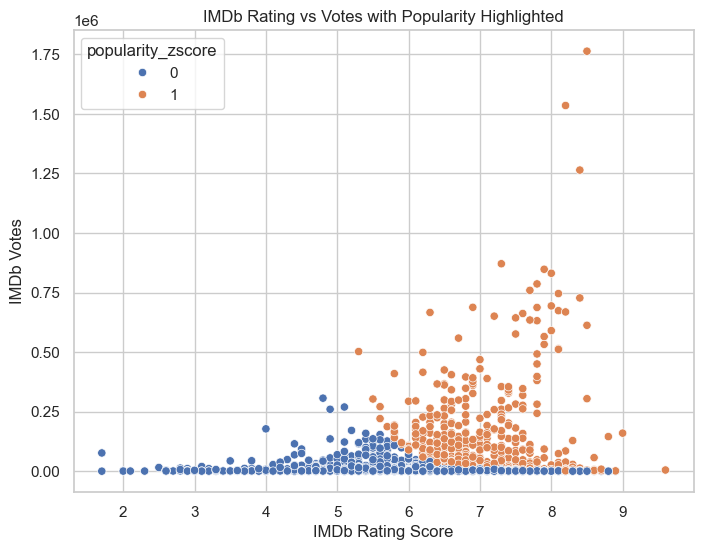

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")
sns.scatterplot(data=df, x='imdbrating', y='imdbvotes', hue='popularity_zscore')

plt.title("IMDb Rating vs Votes with Popularity Highlighted")
plt.xlabel("IMDb Rating Score")
plt.ylabel("IMDb Votes")
plt.grid(True)
plt.show()

C:\Users\jiehe\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\jiehe\AppData\Local\Temp\ipykernel_20276\1362448181.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tv_shows_df['popularity_cluster'] = kmeans_tv.fit_predict(tv_shows_scaled)
C:\Users\jiehe\AppData\Local\Temp\ipykernel_20276\1362448181.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

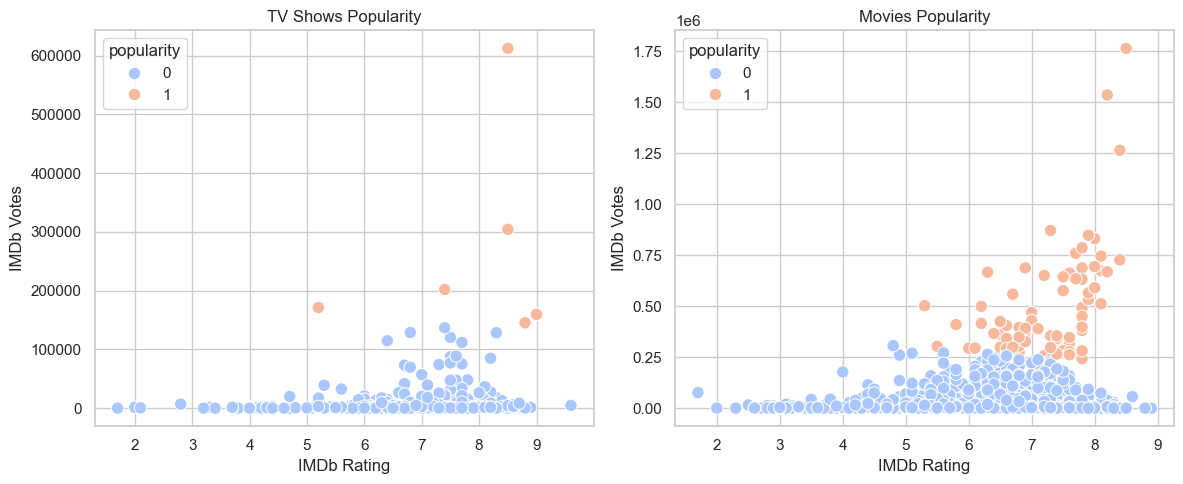

TV Shows Clusters Centers:
[[-0.01358393 -0.09137669]
 [ 0.89880346  6.04609077]]
Movies Clusters Centers:
[[-0.05037222 -0.1858654 ]
 [ 0.94384942  3.48265294]]


In [56]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


tv_shows_df = df[df['type'] == 1]
movies_df = df[df['type'] == 0]


scaler = StandardScaler()

tv_shows_scaled = scaler.fit_transform(tv_shows_df[['imdbrating', 'imdbvotes']])


movies_scaled = scaler.fit_transform(movies_df[['imdbrating', 'imdbvotes']])


kmeans_tv = KMeans(n_clusters=2, random_state=42)
tv_shows_df['popularity_cluster'] = kmeans_tv.fit_predict(tv_shows_scaled)

kmeans_movies = KMeans(n_clusters=2, random_state=42)
movies_df['popularity_cluster'] = kmeans_movies.fit_predict(movies_scaled)


tv_shows_df['popularity'] = tv_shows_df['popularity_cluster'].apply(lambda x: 1 if x == np.argmax(kmeans_tv.cluster_centers_[:, 0]) else 0)
movies_df['popularity'] = movies_df['popularity_cluster'].apply(lambda x: 1 if x == np.argmax(kmeans_movies.cluster_centers_[:, 0]) else 0)


df_updated = pd.concat([tv_shows_df, movies_df], ignore_index=True)

plt.figure(figsize=(12, 5))

# TV Shows
plt.subplot(1, 2, 1)
sns.scatterplot(data=tv_shows_df, x='imdbrating', y='imdbvotes', hue='popularity', palette='coolwarm', s=80)
plt.title('TV Shows Popularity')
plt.xlabel('IMDb Rating')
plt.ylabel('IMDb Votes')

# Movies
plt.subplot(1, 2, 2)
sns.scatterplot(data=movies_df, x='imdbrating', y='imdbvotes', hue='popularity', palette='coolwarm', s=80)
plt.title('Movies Popularity')
plt.xlabel('IMDb Rating')
plt.ylabel('IMDb Votes')

plt.tight_layout()
plt.show()


print("TV Shows Clusters Centers:")
print(kmeans_tv.cluster_centers_)

print("Movies Clusters Centers:")
print(kmeans_movies.cluster_centers_)

In [30]:
# Calculate the median of imdbvotes for each type
vote_threshold_type0 = df[df['type'] == 0]['imdbvotes'].median()
vote_threshold_type1 = df[df['type'] == 1]['imdbvotes'].median()
rating_threshold_type0 = df[df['type'] == 0]['imdbrating'].quantile(0.6)
rating_threshold_type1 = df[df['type'] == 1]['imdbrating'].quantile(0.6) 
                      
# Define a function to determine popularity (based on type-specific vote median)
def is_popular(row):
    if row['type'] == 0:  # Movie
        if row['imdbrating'] > rating_threshold_type0 and row['imdbvotes'] > vote_threshold_type0:
            return 1
    elif row['type'] == 1:  # TV Show
        if row['imdbrating'] > rating_threshold_type1 and row['imdbvotes'] > vote_threshold_type1:
            return 1
    return 0
print("Vote threshold for movies (type 0):", vote_threshold_type0)
print("Vote threshold for TV shows (type 1):", vote_threshold_type1)
print("Rating threshold for movies (60th percentile):", rating_threshold_type0)
print("Rating threshold for TV shows (60th percentile):", rating_threshold_type1)
# Apply the popularity rule to the dataset
df['popularity'] = df.apply(is_popular, axis=1)

Vote threshold for movies (type 0): 4993.0
Vote threshold for TV shows (type 1): 2013.0
Rating threshold for movies (60th percentile): 6.6
Rating threshold for TV shows (60th percentile): 7.3


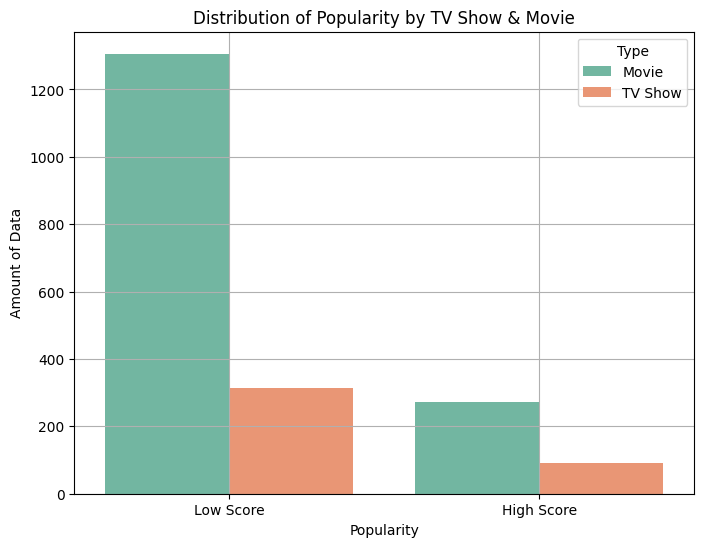

In [42]:
# Convert type column to categorical labels
df['type_label'] = df['type'].map({0: "Movie", 1: "TV Show"})

# Plot the grouped bar chart
plt.figure(figsize=(8, 6))

# Use 'type_label' as hue to group by TV Show & Movie
scatter = sns.countplot(x='popularity', data=df, hue='type_label', palette='Set2')

plt.title('Distribution of Popularity by TV Show & Movie')
plt.xlabel('Popularity')
plt.ylabel('Amount of Data')
plt.xticks([0, 1], ["Low Score", "High Score"])

# Customize legend labels
plt.legend(title="Type")

plt.grid()
plt.show()

In [43]:
df.to_csv("netflix_imdb_clean.csv", index=False)
print("✅ Query completed. Results saved as 'netflix_imdb_clean.csv'")

✅ Query completed. Results saved as 'netflix_imdb_clean.csv'


In [70]:
import pandas as pd

df = pd.read_csv("/Users/deekshantkaul/Downloads/netflix_imdb_clean.csv")
df.head(10)

unnamed:_0 show_id  type  \
0           0      s1     0   
1           9     s10     0   
2          27     s28     0   
3          28     s29     0   
4          40     s41     1   
5          48     s49     0   
6          81     s82     0   
7          96     s97     0   
8          97     s98     1   
9         101    s102     0   

                                               title  \
0                               dick johnson is dead   
1                                       the starling   
2                                          grown ups   
3                                         dark skies   
4             he-man and the masters of the universe   
5                                       training day   
6                                               kate   
7  if i leave here tomorrow: a film about lynyrd ...   
8                                         kid cosmic   
9                             untold: breaking point   

                   director  \
0           kirsten johnson   
1            theodore melfi   
2              dennis dugan   
3             scott stewart   
4                       NaN   
5             antoine fuqua   
6     cedric nicolas-troyan   
7             stephen kijak   
8                       NaN   
9  chapman way, maclain way   

                                                cast  date_added  \
0                                                Nan  2021-09-25   
1  Melissa Mccarthy, Chris O'Dowd, Kevin Kline, T...  2021-09-24   
2  Adam Sandler, Kevin James, Chris Rock, David S...  2021-09-20   
3  Keri Russell, Josh Hamilton, J.K. Simmons, Dak...  2021-09-19   
4  Yuri Lowenthal, Kimberly Brooks, Antony Del Ri...  2021-09-16   
5  Denzel Washington, Ethan Hawke, Scott Glenn, T...  2021-09-16   
6  Mary Elizabeth Winstead, Jun Kunimura, Woody H...  2021-09-10   
7  Ronnie Van Zandt, Gary Rossington, Allen Colli...  2021-09-07   
8  Jack Fisher, Tom Kenny, Amanda C. Miller, Kim ...  2021-09-07   
9                                                Nan  2021-09-07   

   release_year  rating                                   listed_in  ...  \
0          2020       6                               documentaries  ...   
1          2021       6                            comedies, dramas  ...   
2          2010       6                                    comedies  ...   
3          2013       6             horror movies, sci-fi & fantasy  ...   
4          2021      13               kids' tv, tv sci-fi & fantasy  ...   
5          2001       7                           dramas, thrillers  ...   
6          2021       7                          action & adventure  ...   
7          2018      10             documentaries, music & musicals  ...   
8          2021      13  kids' tv, tv comedies, tv sci-fi & fantasy  ...   
9          2021      10                documentaries, sports movies  ...   

                                            keywords  votes_log  rating_z  \
0       ['death', 'father', 'help', 'life', 'young']   8.904494  0.933416   
1    ['struggling', 'way', 'woman', 'life', 'young']   9.668082  0.078820   
2         ['house', 'high', 'help', 'film', 'finds']  12.589820 -0.263019   
3        ['home', 'family', 'life', 'group', 'film']  11.305926 -0.006640   
4        ['teen', 'young', 'group', 'film', 'finds']   7.751475 -0.348479   
5       ['day', 'young', 'help', 'finds', 'follows']  13.106378  1.275255   
6      ['young', 'help', 'film', 'finds', 'follows']  11.208762 -0.006640   
7  ['story', 'man', 'documentary', 'family', 'film']   7.426549  1.275255   
8           ['boy', 'day', 'true', 'finds', 'young']   7.515345  1.360715   
9      ['american', 'life', 'help', 'film', 'finds']   8.130059  1.104336   

    votes_z  popularity_score popularity_zscore  popularity_cluster  \
0  0.195915          0.564666                 1                   0   
1  0.533976          0.306398                 0                   0   
2  1.827511          0.782246                 1        

In [69]:
print(df['type'].unique())

[0 1]


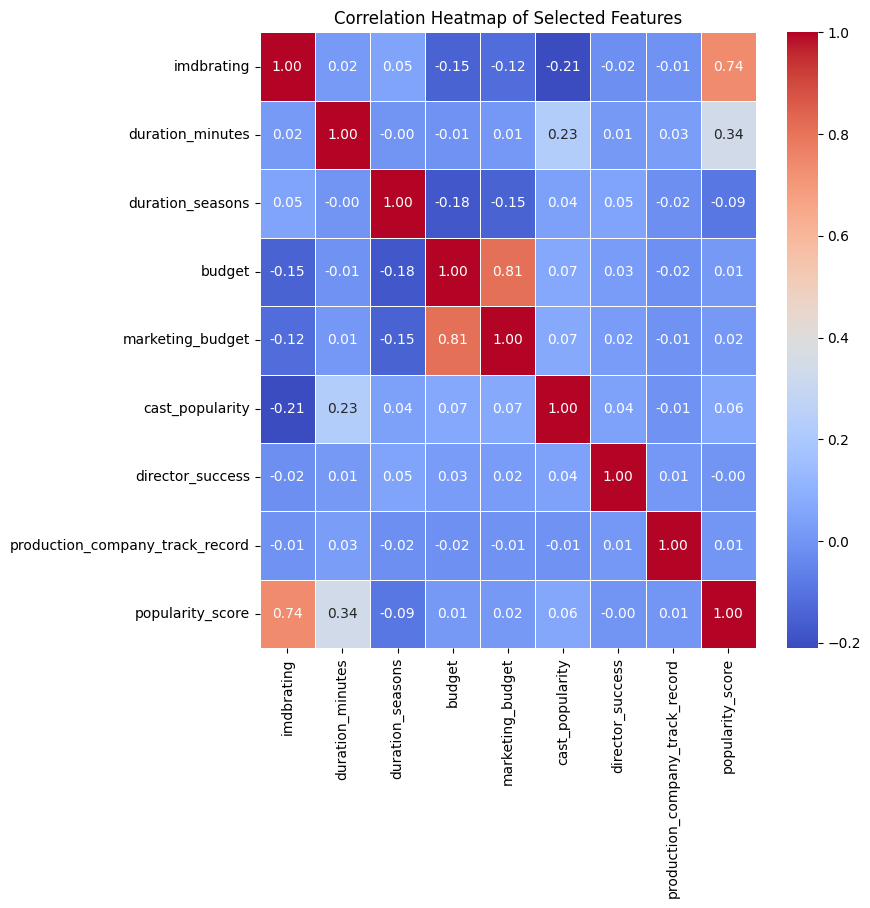

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

corr_columns = [
    'imdbrating', 
    'duration_minutes',
    'duration_seasons',
    'budget', 
    'marketing_budget', 
    'cast_popularity', 
    'director_success', 
    'production_company_track_record', 
    'popularity_score'
]
corr_matrix = df[corr_columns].corr()

# Plot the heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap of Selected Features")
plt.show()

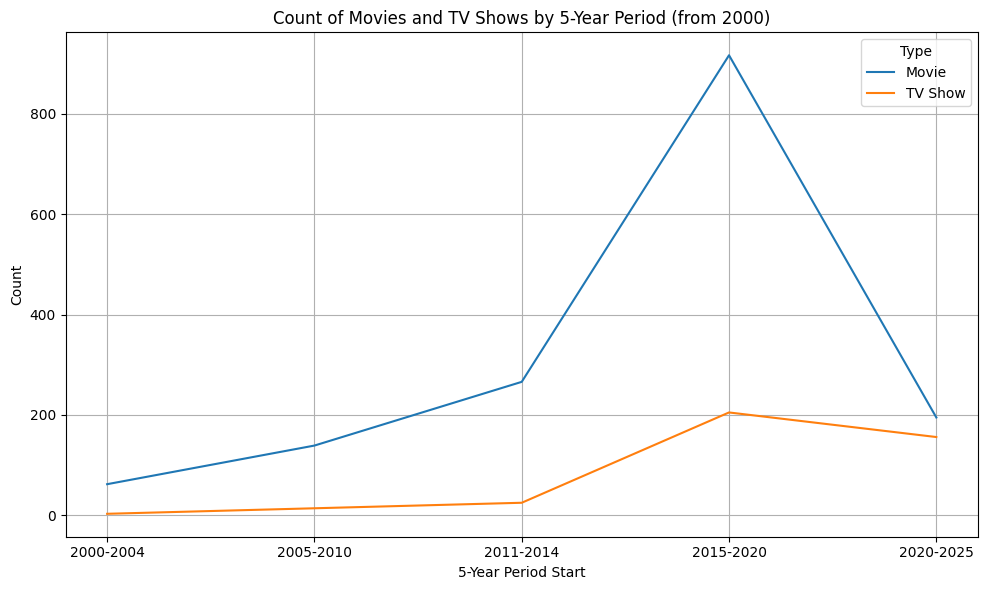

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



# Ensure 'release_year' is integer
df['release_year'] = pd.to_numeric(df['release_year'], errors='coerce')

bins = [2000, 2005, 2010, 2015, 2020, 2025]
labels = ['2000-2004', '2005-2010', '2011-2014', '2015-2020', '2020-2025']
df['decade_bin'] = pd.cut(df['release_year'], bins=bins, labels=labels, right=False)

# Map 'type' 0 → Movie, 1 → TV Show for clarity
df['type_label'] = df['type'].map({0: 'Movie', 1: 'TV Show'})

# Group by period and type, then count
count_df = df.groupby(['decade_bin', 'type_label']).size().reset_index(name='count')

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=count_df, x='decade_bin', y='count', hue='type_label')
plt.title("Count of Movies and TV Shows by 5-Year Period (from 2000)")
plt.xlabel("5-Year Period Start")
plt.ylabel("Count")
plt.xticks()
plt.grid()
plt.legend(title='Type')
plt.tight_layout()
plt.show()

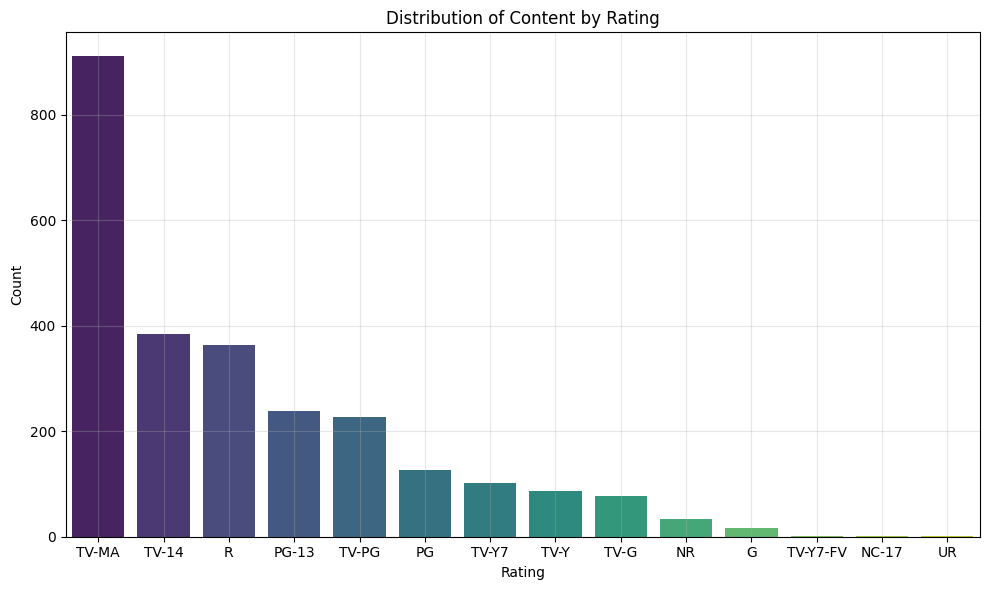

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Check unique ratings

df1 = pd.read_csv("/Users/deekshantkaul/Downloads/netflix_titles.csv")
#print("Unique ratings:", df1['rating'].unique())
df1['rating'] = df1['rating'].replace('NA', np.nan)
df1['rating'] = df1['rating'].fillna(0)
#print(df1['rating'].isna().sum())
df2 = df1[(pd.to_numeric(df1['release_year'], errors='coerce') >= 2000) & (df1['country'].str.strip() == 'United States')]
df3 = df2[~df2['rating'].str.contains(' min', na=False)]
# Count the number of entries per rating
rating_counts = df3['rating'].value_counts().reset_index()
rating_counts.columns = ['rating', 'count']

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=rating_counts, x='rating', y='count', palette='viridis')

plt.title("Distribution of Content by Rating")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.xticks()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


0
       type budget_bin  count
0     Movie       0–5M      0
1     Movie      5–10M     42
2     Movie     10–20M    110
3     Movie     20–50M    297
4     Movie    50–100M    556
5     Movie      100M+    574
6   TV Show       0–5M    190
7   TV Show      5–10M    213
8   TV Show     10–20M      0
9   TV Show     20–50M      0
10  TV Show    50–100M      0
11  TV Show      100M+      0


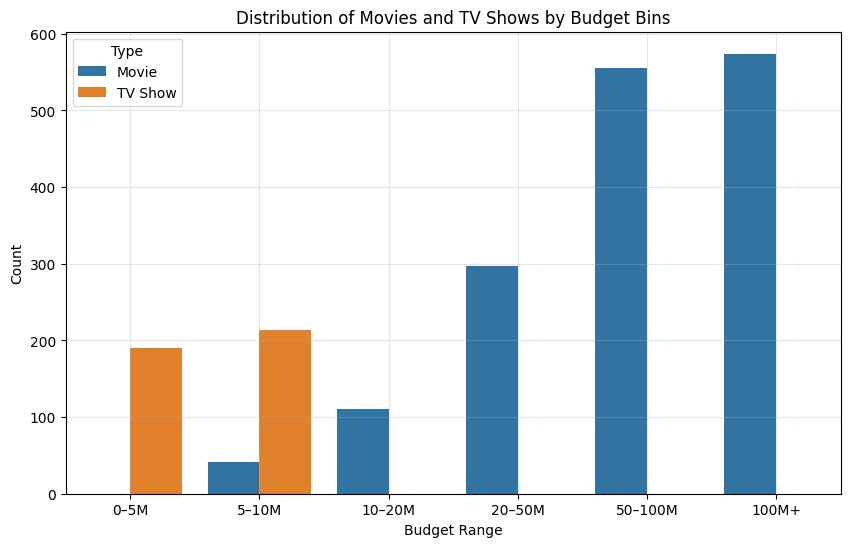

In [71]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Check missing budgets
print(df['budget'].isnull().sum())

# Drop rows with missing budget if needed
df = df[df['budget'].notnull()]

bins = [0, 5e6, 10e6, 20e6, 50e6, 100e6, df['budget'].max() + 1]
labels = ['0–5M', '5–10M', '10–20M', '20–50M', '50–100M', '100M+']

df['budget_bin'] = pd.cut(df['budget'], bins=bins, labels=labels)

# Map type early
df['type'] = df['type'].map({0: 'Movie', 1: 'TV Show'})

# Group by type string and budget bin
budget_dist = df.groupby(['type', 'budget_bin']).size().reset_index(name='count')

print(budget_dist)

plt.figure(figsize=(10, 6))
sns.barplot(data=budget_dist, x='budget_bin', y='count', hue='type')
plt.title('Distribution of Movies and TV Shows by Budget Bins')
plt.xlabel('Budget Range')
plt.ylabel('Count')
plt.grid(alpha=0.3)
plt.legend(title='Type')
plt.show()

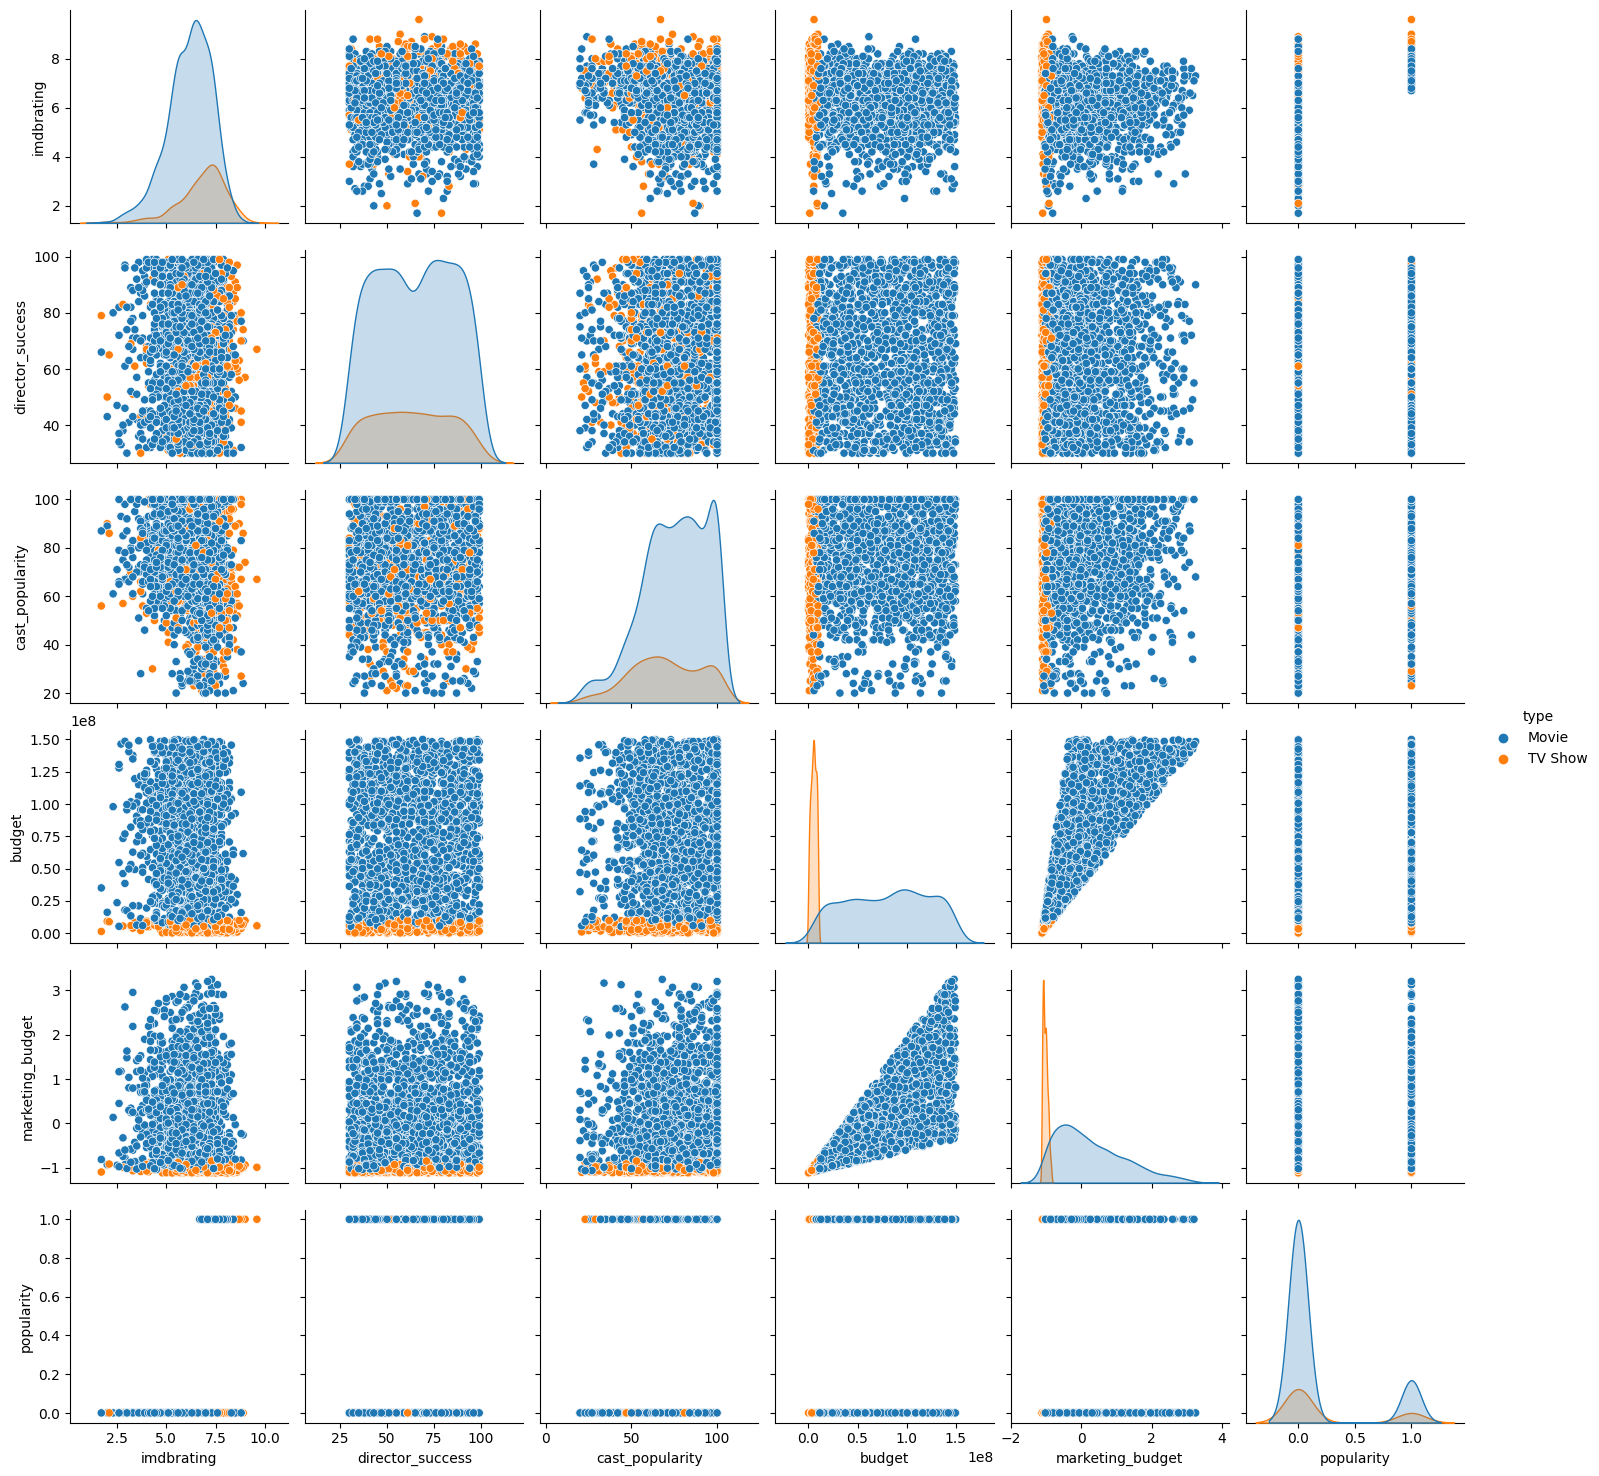

In [107]:
# Clean the column names if needed
df.columns = df.columns.str.strip()

# Convert 'type' from 0/1 to descriptive labels
df['type'] = df['type'].map({0: 'Movie', 1: 'TV Show'})

# Convert to categorical type if needed
df['type'] = df['type'].astype('category')

# Remove rows with missing values in 'type' column
df = df.dropna(subset=['type'])

# Ensure the 'type' column is valid
if 'type' in df.columns:
    sns.pairplot(df[['imdbrating', 'director_success', 'cast_popularity', 'budget', 'marketing_budget', 'type', 'popularity']], hue='type')
    plt.show()
else:
    print("The 'type' column is missing or invalid.")

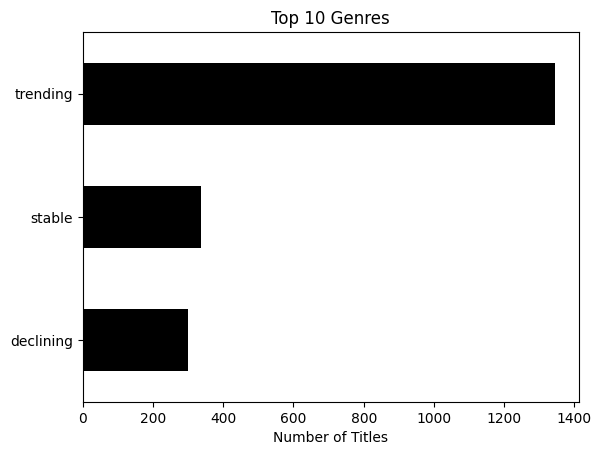

In [101]:
top_genres = df['genre_trend'].value_counts().nlargest(10)
top_genres.plot(kind='barh', color='black')
plt.title('Top 10 Genres')
plt.xlabel('Number of Titles')
plt.gca().invert_yaxis()
plt.show()